# ACS Adoption Meta Analysis

**Objective**: Comparative analysis across regions on ACS adoption, focusing on KOR and JPN where ACS adoption rate is significantly lower compared to other regions.

**Scope** (this notebook):
- Genre / sub-genre patterns by ACS mode across regions
- Campaign target country patterns by ACS mode across regions

**Out of scope** (handled by global workstream):
- Impression share analysis

**Key Tables**:
- `ads-bpd-guard-china.standard_digest.history_digest` — ACS type per product (via `inventory_feature.acs_type`)
- `ads-bpd-guard-china.athena.fact_dsp_core` — spend & performance with advertiser office/region, product genre, campaign country
- `moloco-ae-view.athena.dim1_app` — app metadata (genre, sub-genre from data.ai)

**ACS Modes**: `ACS_STANDARD_ADVANCED`, `ACS_STANDARD_RECOMMENDED`, `ACS_STANDARD_CONSERVATIVE`, `NO_ACS` / null

---
Ref: [MA DS: ACS adoption meta analysis](https://docs.google.com/document/d/18okXtBAgXh3E3KsMPxHmN1TjgybQDcpLmlx01O4jgdY)

In [157]:
#@title Environment Setup

from google.cloud import bigquery

import os
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


client = bigquery.Client(project='moloco-ods')

def process_query(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    df_return = query_job.result().to_dataframe()
    return df_return

def process_query_be(input_query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(input_query, job_config=job_config)
    print(f"Submitted job: {query_job.job_id}")
    return query_job

def fetch_result(query_job):
    try:
        if query_job.done():
            if query_job.error_result:
                print(f"Job {query_job.job_id} failed: {query_job.error_result}")
                return {"status": "error", "job_id": query_job.job_id, "error": query_job.error_result}
            else:
                print(f"Job {query_job.job_id} is complete!")
                df_return = query_job.result().to_dataframe()
                return {"status": "success", "job_id": query_job.job_id, "data": df_return}
        else:
            print(f"Job {query_job.job_id} is still running...")
            return None
    except Exception as e:
        print(f"Job {query_job.job_id} raised an exception: {e}")
        return {"status": "exception", "job_id": query_job.job_id, "error": str(e)}

In [158]:
#@title Configuration

# Analysis period (recent 90 days for meaningful spend volume)
START_DATE = '2025-11-01'
END_DATE = '2026-01-31'

# Regions of interest
FOCUS_OFFICES = ['KOR', 'JPN']

# Minimum spend threshold (USD) for a product to be included
MIN_SPEND_USD = 100

---
## 1. Data Pull: ACS Mode × Spend × Genre/Subgenre × Region × Target Country

We join:
1. **ACS type** from `history_digest` (product-level, latest per product per date)
2. **Spend & campaign attributes** from `fact_dsp_core` (advertiser office/region, campaign country, product genre)

The ACS type is stored at the **product** level in `history_digest.original_json → $.inventory_feature.acs_type`.

In [159]:
#@title Data Pull — ACS adoption base dataset

query_acs_base = f"""
WITH acs_product AS (
  -- Latest ACS type per product within the analysis period
  SELECT
    JSON_VALUE(digest_json, '$.id') AS product_id,
    `date` AS date_utc,
    JSON_VALUE(original_json, '$.inventory_feature.acs_type') AS acs_type
  FROM `ads-bpd-guard-china.standard_digest.history_digest`
  WHERE type = 'PRODUCT'
    AND `date` BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND platform != 'MOLOCO'
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY JSON_VALUE(digest_json, '$.id'), `date`
    ORDER BY `date` DESC
  ) = 1
),

spend_base AS (
  -- Spend aggregated by key dimensions
  SELECT
    f.date_utc,
    f.advertiser.office AS office,
    f.advertiser.office_region AS office_region,
    f.product_id,
    f.product.app_market_bundle,
    f.product.genre,
    f.product.sub_genre,
    f.product.is_gaming,
    f.campaign.country AS campaign_country,
    f.campaign.os AS campaign_os,
    f.campaign.goal AS campaign_goal,
    f.campaign.type AS campaign_type,
    f.campaign_id,
    SUM(f.gross_spend_usd) AS gross_spend_usd,
    SUM(f.impressions) AS impressions,
    SUM(f.clicks) AS clicks,
    SUM(f.installs) AS installs,
    SUM(f.clicks_ev) AS clicks_ev,
    SUM(f.clicks_ec) AS clicks_ec
  FROM `ads-bpd-guard-china.athena.fact_dsp_core` f
  WHERE f.date_utc BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND f.gross_spend_usd > 0
  GROUP BY ALL
)

SELECT
  s.*,
  COALESCE(a.acs_type, 'NO_ACS') AS acs_type,
  -- Simplified ACS mode label
  CASE
    WHEN a.acs_type = 'ACS_STANDARD_ADVANCED' THEN 'Advanced'
    WHEN a.acs_type = 'ACS_STANDARD_RECOMMENDED' THEN 'Recommended'
    WHEN a.acs_type = 'ACS_STANDARD_CONSERVATIVE' THEN 'Conservative'
    WHEN a.acs_type IS NULL THEN 'No ACS'
    ELSE a.acs_type
  END AS acs_mode
FROM spend_base s
LEFT JOIN acs_product a
  ON s.product_id = a.product_id
  AND s.date_utc = a.date_utc
"""

print("Submitting ACS base data query...")
job_acs_base = process_query_be(query_acs_base)

Submitting ACS base data query...
Submitted job: 2e777e8e-b74e-49aa-acf9-7a942a8dd95c


In [130]:
#@title Fetch result
result = fetch_result(job_acs_base)
if result and result['status'] == 'success':
    df = result['data']
    print(f"Rows: {len(df):,}, Columns: {df.columns.tolist()}")
    print(f"Date range: {df['date_utc'].min()} — {df['date_utc'].max()}")
    print(f"\nACS mode distribution (by row count):")
    print(df['acs_mode'].value_counts())
    df.head()

Job 203b2d62-6b7f-42b3-bfa3-72e6cad53a03 is complete!
Rows: 9,603,853, Columns: ['date_utc', 'office', 'office_region', 'product_id', 'app_market_bundle', 'genre', 'sub_genre', 'is_gaming', 'campaign_country', 'campaign_os', 'campaign_goal', 'campaign_type', 'campaign_id', 'gross_spend_usd', 'impressions', 'clicks', 'installs', 'clicks_ev', 'clicks_ec', 'acs_type', 'acs_mode']
Date range: 2025-11-01 — 2026-01-31

ACS mode distribution (by row count):
acs_mode
Recommended     4499515
Advanced        4403696
Conservative     461027
ACS_CUSTOM       217782
No ACS            21032
ACS_UNKNOWN         801
Name: count, dtype: int64


In [131]:
#@title Sanity check: ACS mode values & completeness

# Check for unexpected acs_mode values beyond the 4 expected
print("=== Distinct acs_mode values ===")
print(df['acs_mode'].value_counts())
print(f"\n=== Distinct raw acs_type values ===")
print(df['acs_type'].value_counts())

# Verify spend shares sum to 100% per office
check = (
    df.groupby(['office', 'acs_mode'])['gross_spend_usd'].sum()
    .unstack(fill_value=0)
)
check['total'] = check.sum(axis=1)
check['sum_pct'] = check.drop(columns='total').sum(axis=1) / check['total'] * 100
print(f"\n=== Spend share sum per office (should all be 100%) ===")
print(check['sum_pct'].astype(float).round(1))

=== Distinct acs_mode values ===
acs_mode
Recommended     4499515
Advanced        4403696
Conservative     461027
ACS_CUSTOM       217782
No ACS            21032
ACS_UNKNOWN         801
Name: count, dtype: int64

=== Distinct raw acs_type values ===
acs_type
ACS_STANDARD_RECOMMENDED     4499515
ACS_STANDARD_ADVANCED        4403696
ACS_STANDARD_CONSERVATIVE     461027
ACS_CUSTOM                    217782
NO_ACS                         21032
ACS_UNKNOWN                      801
Name: count, dtype: int64

=== Spend share sum per office (should all be 100%) ===
office
CHN               100.0
EMEA              100.0
IND               100.0
JPN               100.0
KOR               100.0
SGP               100.0
UNKNOWN_OFFICE    100.0
USA               100.0
Name: sum_pct, dtype: float64


---
## 2. ACS Adoption Rate by Region (Office)

Compare ACS mode distribution (by spend share and product count) across offices/regions. Key question: **How much lower is Advanced ACS adoption in KOR & JPN compared to other offices?**

In [132]:
#@title 2-1. ACS adoption by office — spend share

# Aggregate spend by office × acs_mode
df_office_acs = (
    df.groupby(['office', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)

# Calculate spend share within each office
df_office_acs['total_spend'] = df_office_acs.groupby('office')['spend'].transform('sum')
df_office_acs['spend_share'] = df_office_acs['spend'] / df_office_acs['total_spend']

# Filter to top offices by spend
top_offices = (
    df_office_acs.groupby('office')['spend'].sum()
    .sort_values(ascending=False)
    .head(15)
    .index.tolist()
)
df_plot = df_office_acs[df_office_acs['office'].isin(top_offices)].copy()

# Order ACS modes
acs_order = ['Advanced', 'Recommended', 'Conservative', 'ACS_CUSTOM','No ACS','ACS_UNKNOWN']
df_plot['acs_mode'] = pd.Categorical(df_plot['acs_mode'], categories=acs_order, ordered=True)

# Sort offices by Advanced share descending for comparison
adv_share = (
    df_plot[df_plot['acs_mode'] == 'Advanced']
    .set_index('office')['spend_share']
    .reindex(top_offices, fill_value=0)
    .sort_values(ascending=False)
)
office_order = adv_share.index.tolist()

# Plot
fig = px.bar(
    df_plot,
    x='office',
    y='spend_share',
    color='acs_mode',
    category_orders={'office': office_order, 'acs_mode': acs_order},
    color_discrete_map={
        'Advanced': '#2563eb',
        'Recommended': '#60a5fa',
        'Conservative': '#fbbf24',
        'No ACS': '#d1d5db'
    },
    title=f'ACS Mode Distribution by Office (Spend Share) ({START_DATE} - {END_DATE})',
    labels={'spend_share': 'Spend Share', 'office': 'Office'},
    text_auto='.1%'
)
fig.update_layout(
    barmode='stack',
    yaxis_tickformat='.0%',
    height=500,
    legend_title_text='ACS Mode'
)
fig.show()

In [133]:
#@title 2-2. ACS adoption by office — product count

# Unique products per office × acs_mode (use latest acs_mode per product)
df_product_acs = (
    df.sort_values('date_utc', ascending=False)
    .drop_duplicates(subset=['office', 'product_id'])
    .groupby(['office', 'acs_mode'])
    .agg(n_products=('product_id', 'nunique'))
    .reset_index()
)

df_product_acs['total_products'] = df_product_acs.groupby('office')['n_products'].transform('sum')
df_product_acs['product_share'] = df_product_acs['n_products'] / df_product_acs['total_products']

df_plot2 = df_product_acs[df_product_acs['office'].isin(top_offices)].copy()
df_plot2['acs_mode'] = pd.Categorical(df_plot2['acs_mode'], categories=acs_order, ordered=True)

fig2 = px.bar(
    df_plot2,
    x='office',
    y='product_share',
    color='acs_mode',
    category_orders={'office': office_order, 'acs_mode': acs_order},
    color_discrete_map={
        'Advanced': '#2563eb',
        'Recommended': '#60a5fa',
        'Conservative': '#fbbf24',
        'No ACS': '#d1d5db'
    },
    title=f'ACS Mode Distribution by Office (Product Count Share) ({START_DATE} - {END_DATE})',
    labels={'product_share': 'Product Share', 'office': 'Office'},
    text_auto='.1%'
)
fig2.update_layout(
    barmode='stack',
    yaxis_tickformat='.0%',
    height=500,
    legend_title_text='ACS Mode'
)
fig2.show()

In [134]:
%pip install --upgrade jinja2


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [135]:
#@title 2-3. Summary table: office × ACS mode (spend & product count)

summary_office = (
    df.groupby(['office', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_products=('product_id', 'nunique'),
        n_campaigns=('campaign_id', 'nunique')
    )
    .reset_index()
)

# Pivot for readability
pivot_spend = summary_office.pivot_table(
    index='office', columns='acs_mode', values='spend', aggfunc='sum', fill_value=0
)
pivot_spend['total'] = pivot_spend.sum(axis=1)
pivot_spend = pivot_spend.sort_values('total', ascending=False)

# Show top offices
print("=== Spend (USD) by Office × ACS Mode ===")
pivot_spend.head(15).style.format('${:,.0f}')

=== Spend (USD) by Office × ACS Mode ===


acs_mode,ACS_CUSTOM,ACS_UNKNOWN,Advanced,Conservative,No ACS,Recommended,total
office,,,,,,,
CHN,"$1,216,644","$195,963","$132,125,431","$4,138,351","$1,410,456","$105,331,019","$244,417,865"
EMEA,"$10,216,862","$343,745","$79,452,414","$16,706,346","$722,826","$95,320,486","$202,762,679"
USA,"$30,276,487",$0,"$33,487,690","$20,924,182","$4,292,266","$52,478,419","$141,459,044"
KOR,"$2,407,445",$0,"$3,124,815","$1,311,331","$1,393,689","$23,914,429","$32,151,708"
SGP,"$35,005","$68,399","$10,607,132","$301,157","$15,374","$5,744,985","$16,772,051"
JPN,"$2,740,255",$0,"$1,032,187","$868,971",$0,"$4,539,350","$9,180,763"
IND,"$145,229",$0,"$5,221,144","$76,073",$0,"$932,843","$6,375,290"
UNKNOWN_OFFICE,"$109,798",$0,"$952,699",$0,"$1,097,087","$1,024,867","$3,184,451"


---
## 3. Genre / Sub-genre Analysis by ACS Mode

Identify which genres/sub-genres have high vs. low ACS Advanced adoption, and compare KOR/JPN vs. other regions.

In [136]:
#@title 3-0. Spend distribution across genres by office

top_genres_global = (
    df.groupby('genre')['gross_spend_usd'].sum()
    .sort_values(ascending=False)
    .head(15)
    .index.tolist()
)

df_office_genre = (
    df[df['genre'].isin(top_genres_global)]
    .groupby(['office', 'genre'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_office_genre['total_spend'] = df_office_genre.groupby('office')['spend'].transform('sum')
df_office_genre['spend_share'] = df_office_genre['spend'] / df_office_genre['total_spend']

# Sort genres by global spend for consistent ordering
df_office_genre['genre'] = pd.Categorical(
    df_office_genre['genre'], categories=top_genres_global, ordered=True
)

valid_offices = [o for o in office_order if o in df_office_genre['office'].unique()]

fig_genre_dist = px.bar(
    df_office_genre[df_office_genre['office'].isin(valid_offices)],
    x='genre',
    y='spend_share',
    color='office',
    barmode='group',
    category_orders={'genre': top_genres_global, 'office': valid_offices},
    title='Spend Distribution Across Genres by Office',
    labels={'spend_share': 'Spend Share (within office)', 'genre': 'Genre', 'office': 'Office'},
    text_auto='.0%',
    color_discrete_sequence=px.colors.qualitative.Set2,
)
fig_genre_dist.update_layout(
    yaxis_tickformat='.0%',
    height=550,
    xaxis_tickangle=-45,
    legend_title_text='Office',
)
fig_genre_dist.show()

# Also show as a heatmap for easier comparison
pivot_genre_office = df_office_genre.pivot_table(
    index='genre', columns='office', values='spend_share', fill_value=0
)
pivot_genre_office = pivot_genre_office.reindex(index=top_genres_global, columns=valid_offices)

fig_hm = px.imshow(
    (pivot_genre_office * 100).round(1),
    text_auto='.1f',
    color_continuous_scale='Blues',
    title='Spend Share (%) by Genre × Office',
    labels={'x': 'Office', 'y': 'Genre', 'color': 'Spend %'},
    aspect='auto',
)
fig_hm.update_layout(height=600)
fig_hm.show()

In [137]:
#@title 3-1. ACS adoption by genre (global) — spend-weighted

df_genre_acs = (
    df.groupby(['genre', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_genre_acs['total_spend'] = df_genre_acs.groupby('genre')['spend'].transform('sum')
df_genre_acs['spend_share'] = df_genre_acs['spend'] / df_genre_acs['total_spend']

# Top genres by total spend
top_genres = (
    df_genre_acs.groupby('genre')['spend'].sum()
    .sort_values(ascending=False)
    .head(15)
    .index.tolist()
)
df_genre_plot = df_genre_acs[df_genre_acs['genre'].isin(top_genres)].copy()
df_genre_plot['acs_mode'] = pd.Categorical(df_genre_plot['acs_mode'], categories=acs_order, ordered=True)

# Sort by Advanced spend share
genre_adv = (
    df_genre_plot[df_genre_plot['acs_mode'] == 'Advanced']
    .set_index('genre')['spend_share']
    .reindex(top_genres, fill_value=0)
    .sort_values(ascending=False)
)

fig3 = px.bar(
    df_genre_plot,
    x='genre',
    y='spend_share',
    color='acs_mode',
    category_orders={'genre': genre_adv.index.tolist(), 'acs_mode': acs_order},
    color_discrete_map={
        'Advanced': '#2563eb',
        'Recommended': '#60a5fa',
        'Conservative': '#fbbf24',
        'No ACS': '#d1d5db'
    },
    title='ACS Mode by Genre — Global (Spend Share)',
    labels={'spend_share': 'Spend Share', 'genre': 'Genre'},
    text_auto='.0%'
)
fig3.update_layout(
    barmode='stack',
    yaxis_tickformat='.0%',
    height=500,
    xaxis_tickangle=-45
)
fig3.show()

In [138]:
#@title 3-2. ACS adoption by genre — KOR/JPN vs. Rest

df['region_group'] = df['office'].apply(
    lambda x: x if x in FOCUS_OFFICES else 'Others'
)

df_genre_region = (
    df.groupby(['region_group', 'genre', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_genre_region['total_spend'] = (
    df_genre_region.groupby(['region_group', 'genre'])['spend'].transform('sum')
)
df_genre_region['spend_share'] = df_genre_region['spend'] / df_genre_region['total_spend']

# Filter to top genres
df_genre_region_plot = df_genre_region[
    df_genre_region['genre'].isin(top_genres)
].copy()
df_genre_region_plot['acs_mode'] = pd.Categorical(
    df_genre_region_plot['acs_mode'], categories=acs_order, ordered=True
)

# Faceted bar chart
fig4 = px.bar(
    df_genre_region_plot,
    x='genre',
    y='spend_share',
    color='acs_mode',
    facet_row='region_group',
    category_orders={
        'genre': genre_adv.index.tolist(),
        'acs_mode': acs_order,
        'region_group': ['KOR', 'JPN', 'Others']
    },
    color_discrete_map={
        'Advanced': '#2563eb',
        'Recommended': '#60a5fa',
        'Conservative': '#fbbf24',
        'No ACS': '#d1d5db'
    },
    title='ACS Mode by Genre — KOR vs JPN vs Others (Spend Share)',
    labels={'spend_share': 'Spend Share', 'genre': 'Genre'},
)
fig4.update_layout(
    barmode='stack',
    height=900,
    xaxis_tickangle=-45
)
fig4.update_yaxes(tickformat='.0%')
fig4.show()

In [139]:
#@title 3-3. Sub-genre deep dive — KOR & JPN only

df_focus = df[df['office'].isin(FOCUS_OFFICES)].copy()

df_subgenre = (
    df_focus.groupby(['office', 'genre', 'sub_genre', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_products=('product_id', 'nunique'),
        n_campaigns=('campaign_id', 'nunique')
    )
    .reset_index()
)
df_subgenre['total_spend'] = (
    df_subgenre.groupby(['office', 'genre', 'sub_genre'])['spend'].transform('sum')
)
df_subgenre['spend_share'] = df_subgenre['spend'] / df_subgenre['total_spend']

# Top sub_genres by spend in focus offices
top_subgenres = (
    df_subgenre.groupby(['genre', 'sub_genre'])['spend'].sum()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()[['genre', 'sub_genre']]
)

print("=== Top 20 Genre/Sub-genre combinations in KOR & JPN ===")
for _, row in top_subgenres.iterrows():
    mask = (df_subgenre['genre'] == row['genre']) & (df_subgenre['sub_genre'] == row['sub_genre'])
    subset = df_subgenre[mask].pivot_table(
        index='office', columns='acs_mode', values='spend_share', fill_value=0
    )
    print(f"\n--- {row['genre']} > {row['sub_genre']} ---")
    print(subset.to_string(float_format='{:.1%}'.format))

=== Top 20 Genre/Sub-genre combinations in KOR & JPN ===

--- RPG > Idle RPG ---
acs_mode  ACS_CUSTOM  Advanced  Conservative  Recommended
office                                                   
JPN            20.3%      0.0%         11.6%        68.1%
KOR             0.0%      1.9%          1.1%        96.9%

--- Shopping > E-Commerce ---
acs_mode  ACS_CUSTOM  Advanced  Conservative  Recommended
office                                                   
JPN             0.0%     63.1%          0.0%        36.9%
KOR            52.4%      0.0%         22.1%        25.6%

--- Strategy > Tower Defense Strategy ---
acs_mode  Advanced  Recommended
office                         
JPN           0.0%       100.0%
KOR          49.2%        50.8%

--- Food & Drink > Food Delivery & Carryout ---
acs_mode  Recommended
office               
JPN            100.0%
KOR            100.0%

--- RPG > Team Battle ---
acs_mode  ACS_CUSTOM  Advanced  Conservative  Recommended
office                         

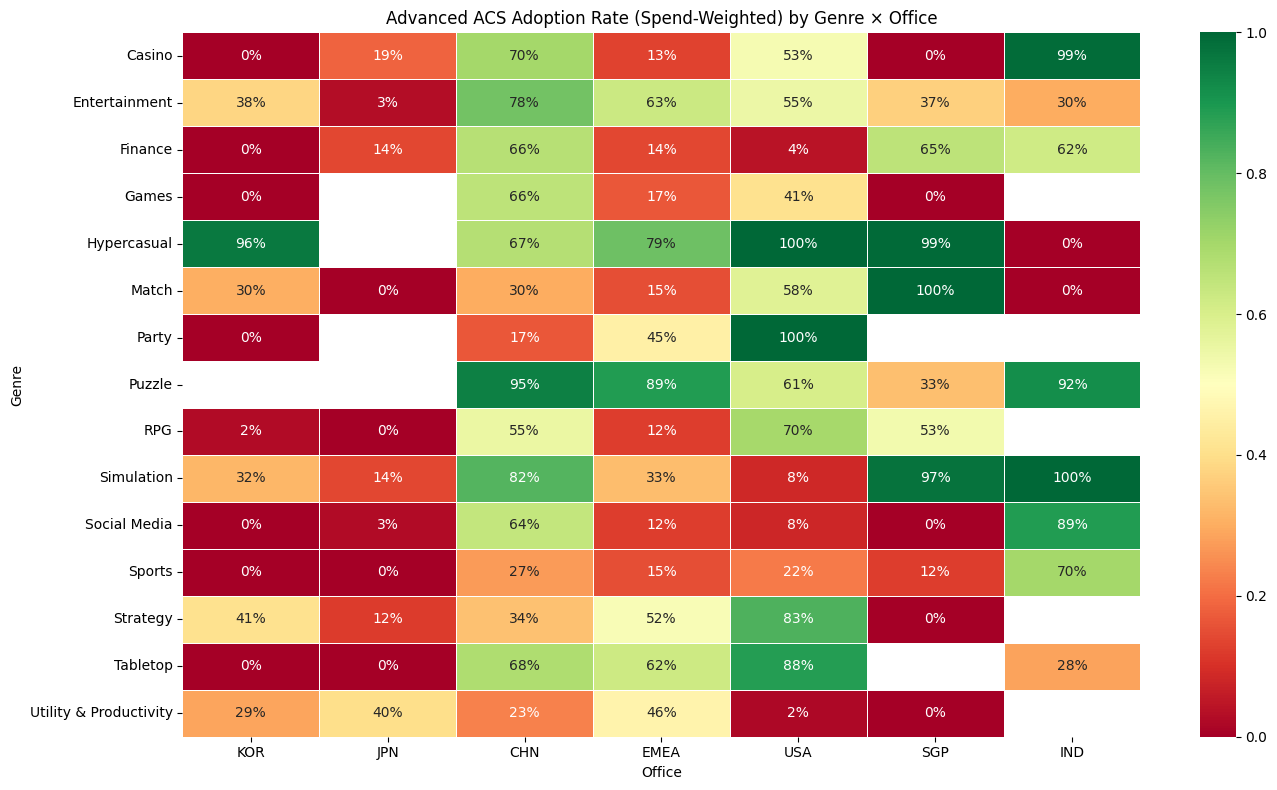

In [140]:
#@title 3-4. Heatmap: Advanced ACS adoption rate by genre × office

df_adv_rate = (
    df.groupby(['office', 'genre'])
    .agg(
        total_spend=('gross_spend_usd', 'sum'),
    )
    .reset_index()
)

df_adv_spend = (
    df[df['acs_mode'] == 'Advanced']
    .groupby(['office', 'genre'])
    .agg(adv_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)

df_heatmap = df_adv_rate.merge(df_adv_spend, on=['office', 'genre'], how='left')
df_heatmap['adv_spend'] = df_heatmap['adv_spend'].fillna(0)
df_heatmap['adv_rate'] = df_heatmap['adv_spend'] / df_heatmap['total_spend']

# Filter to meaningful cells
df_heatmap_filtered = df_heatmap[
    (df_heatmap['office'].isin(top_offices)) &
    (df_heatmap['genre'].isin(top_genres)) &
    (df_heatmap['total_spend'] >= MIN_SPEND_USD)
]

pivot_hm = df_heatmap_filtered.pivot_table(
    index='genre', columns='office', values='adv_rate', fill_value=np.nan
)
# Reorder columns to put focus offices first
col_order = [c for c in FOCUS_OFFICES if c in pivot_hm.columns] + \
            ['CHN','EMEA','USA','SGP','IND']
pivot_hm = pivot_hm[col_order]

fig5, ax5 = plt.subplots(figsize=(14, 8))
sns.heatmap(
    pivot_hm,
    annot=True, fmt='.0%',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    linewidths=0.5,
    ax=ax5
)
ax5.set_title('Advanced ACS Adoption Rate (Spend-Weighted) by Genre × Office')
ax5.set_ylabel('Genre')
ax5.set_xlabel('Office')
plt.tight_layout()
plt.show()

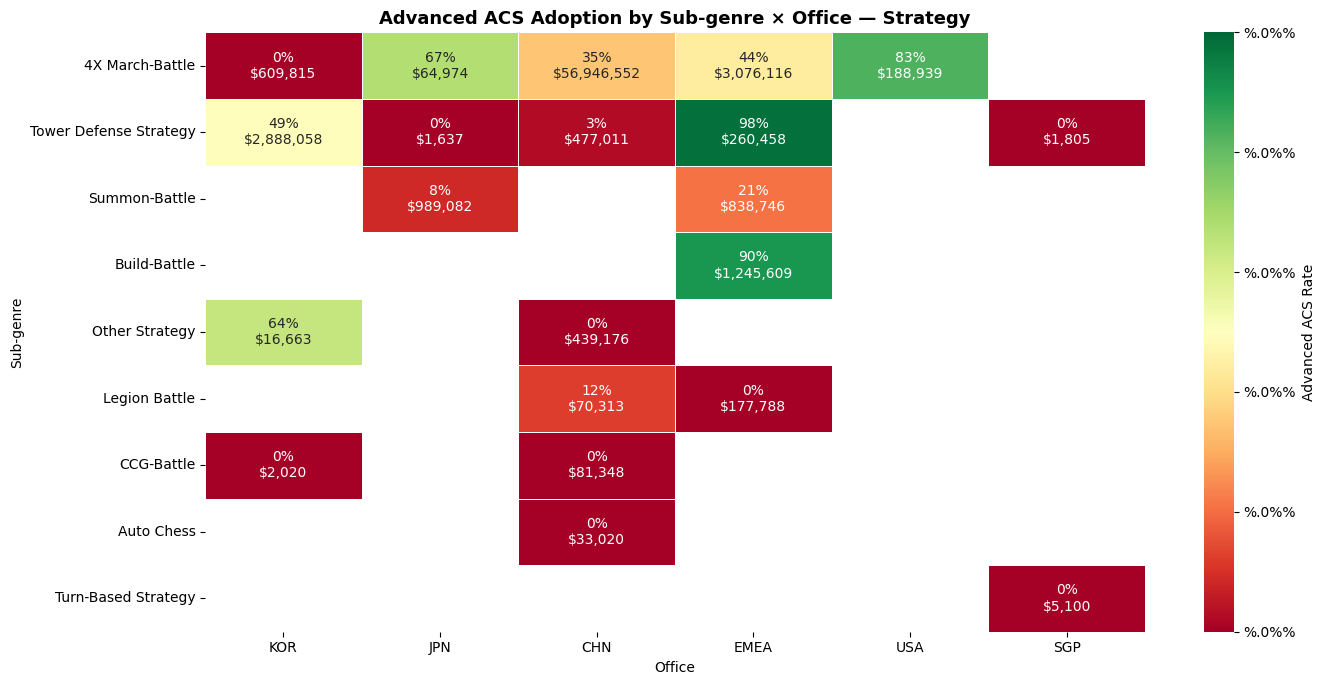

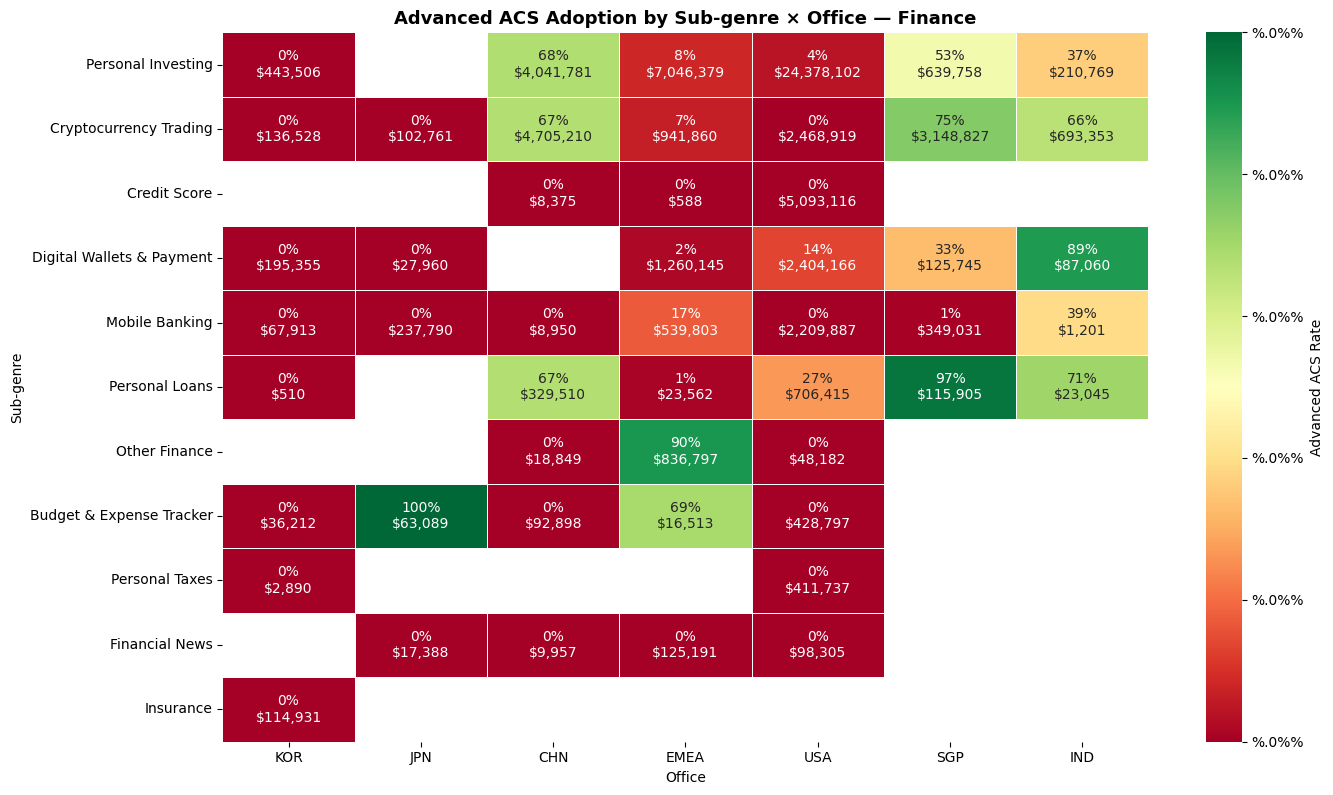

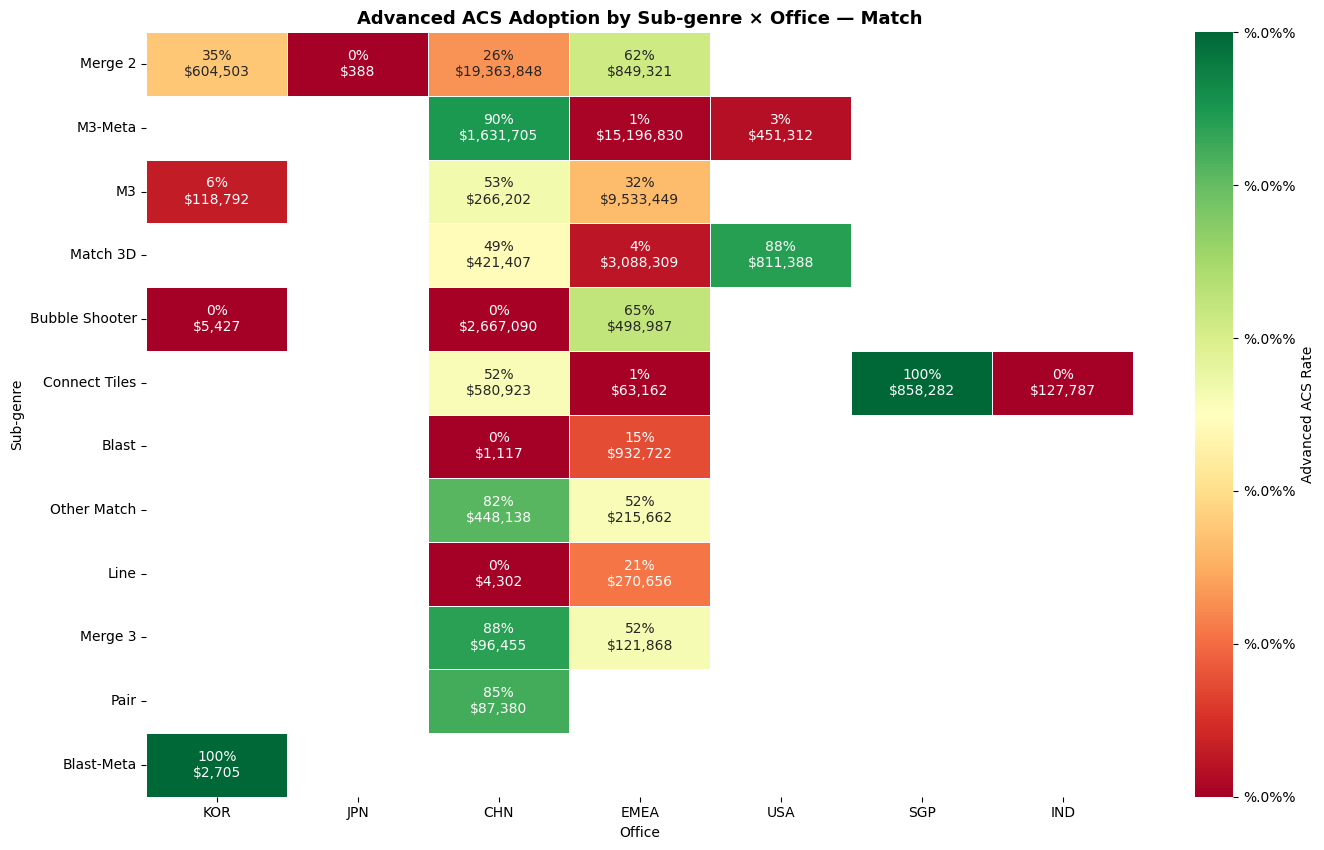

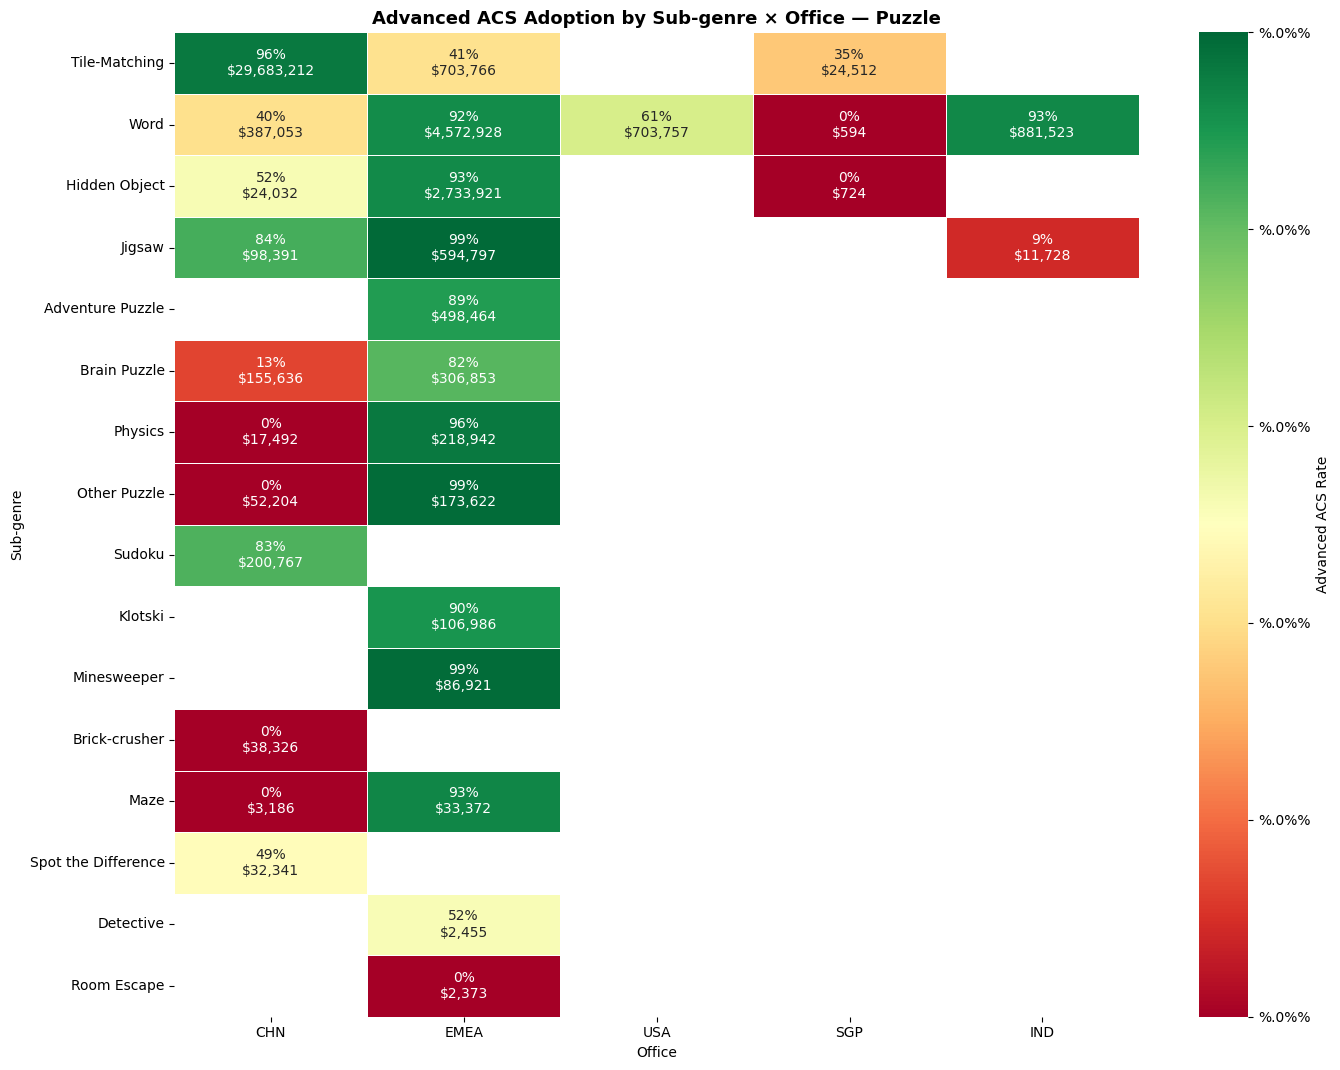

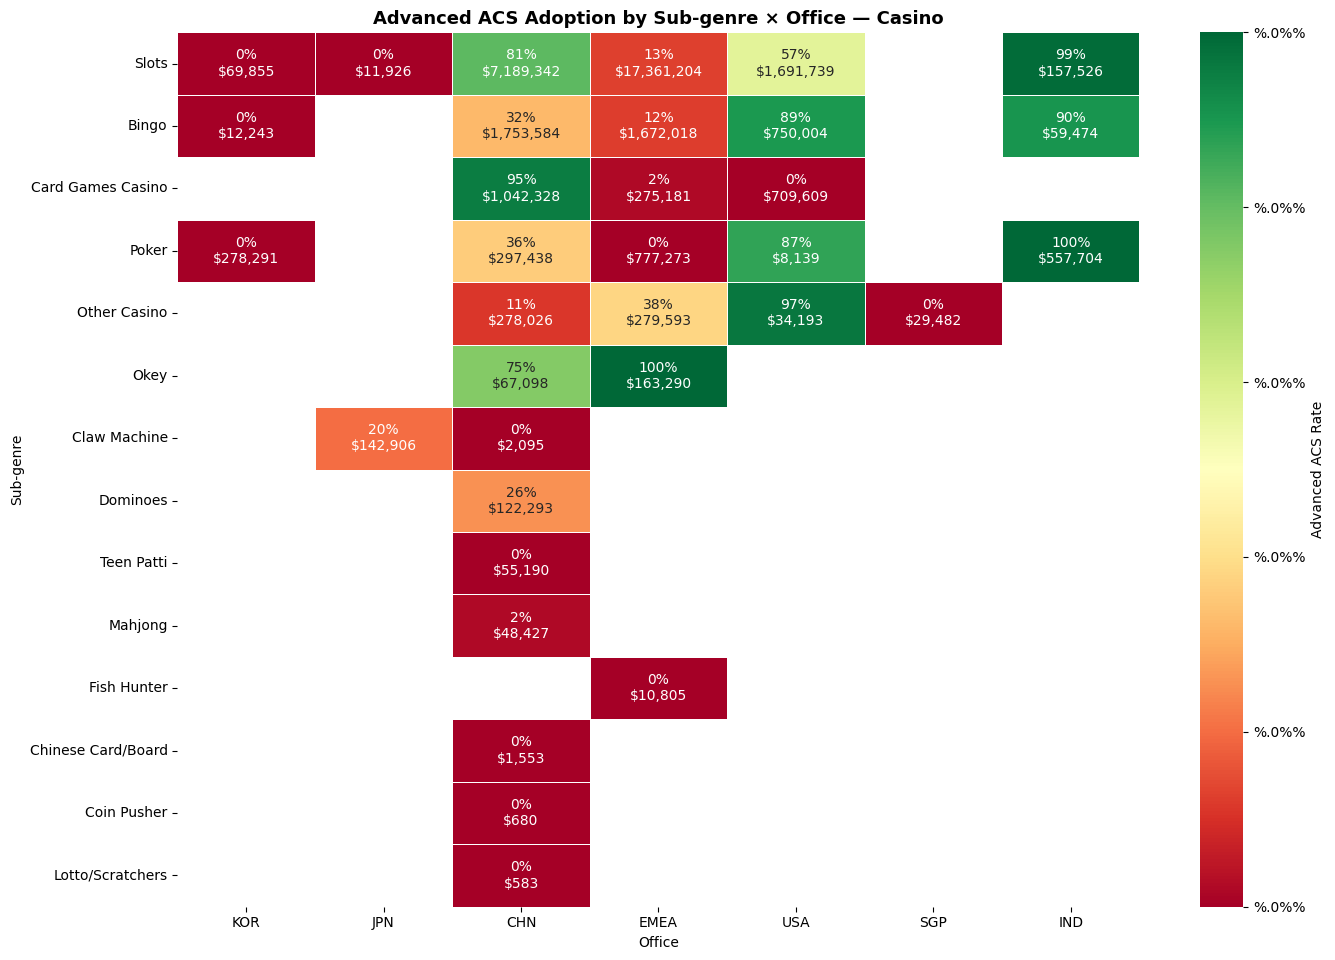

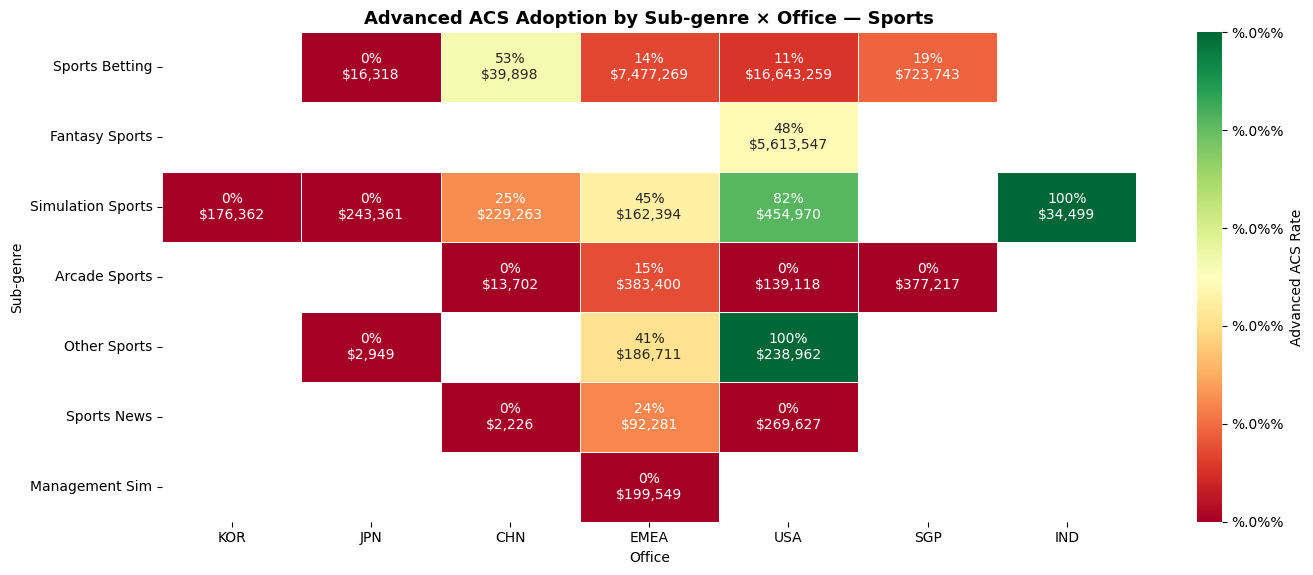

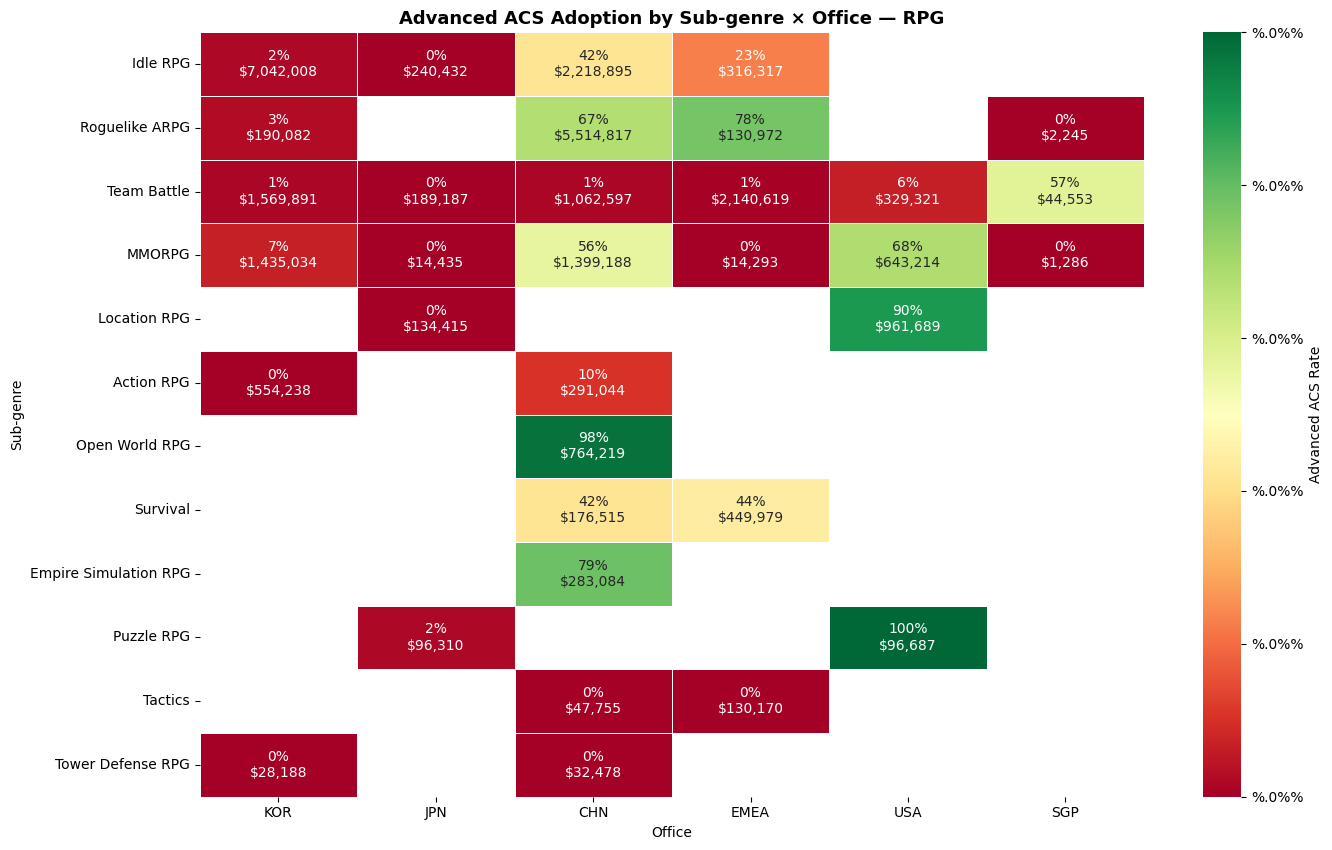

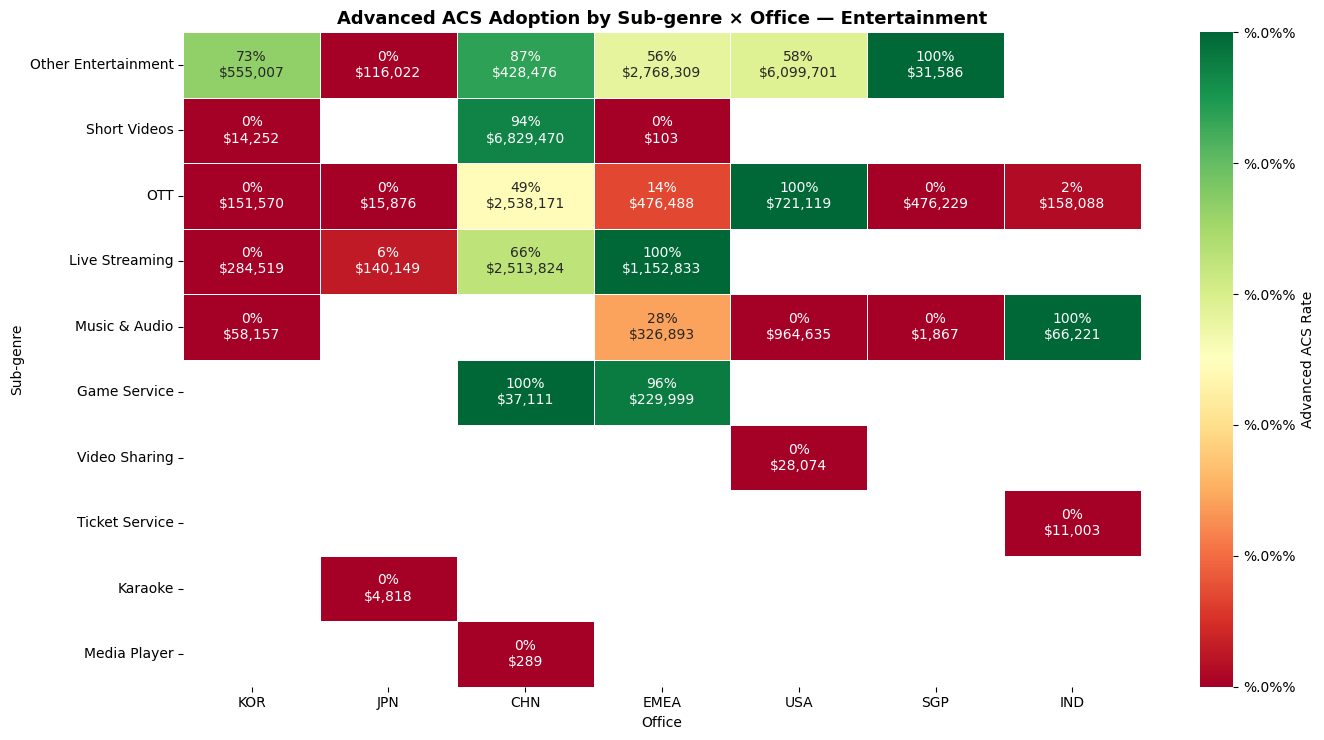

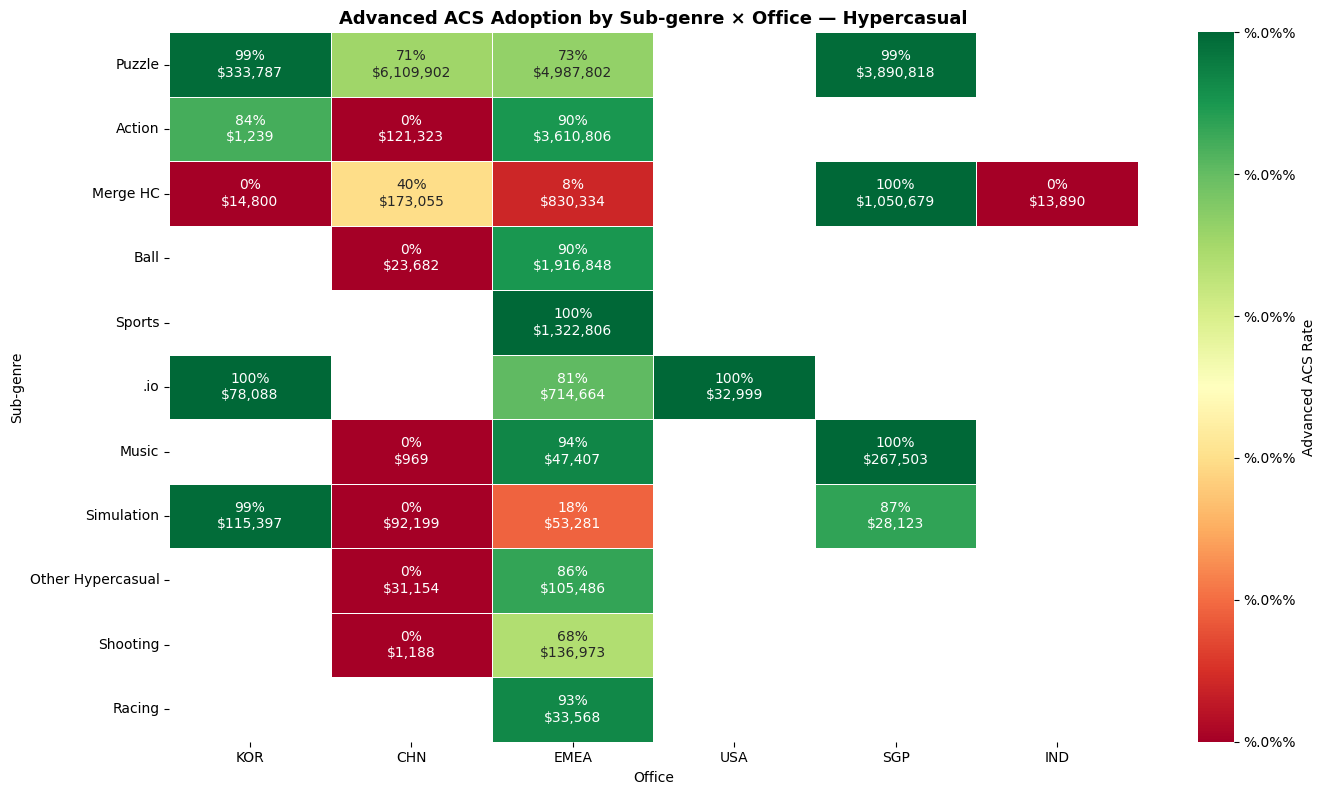

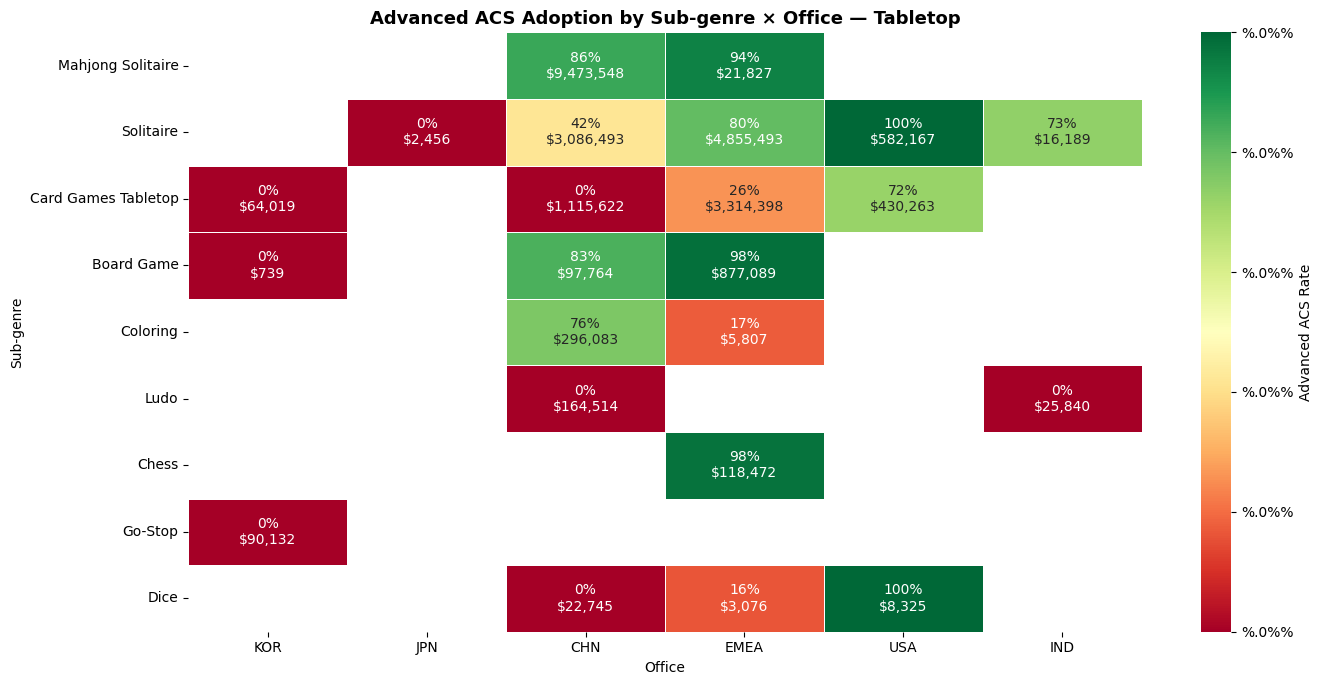

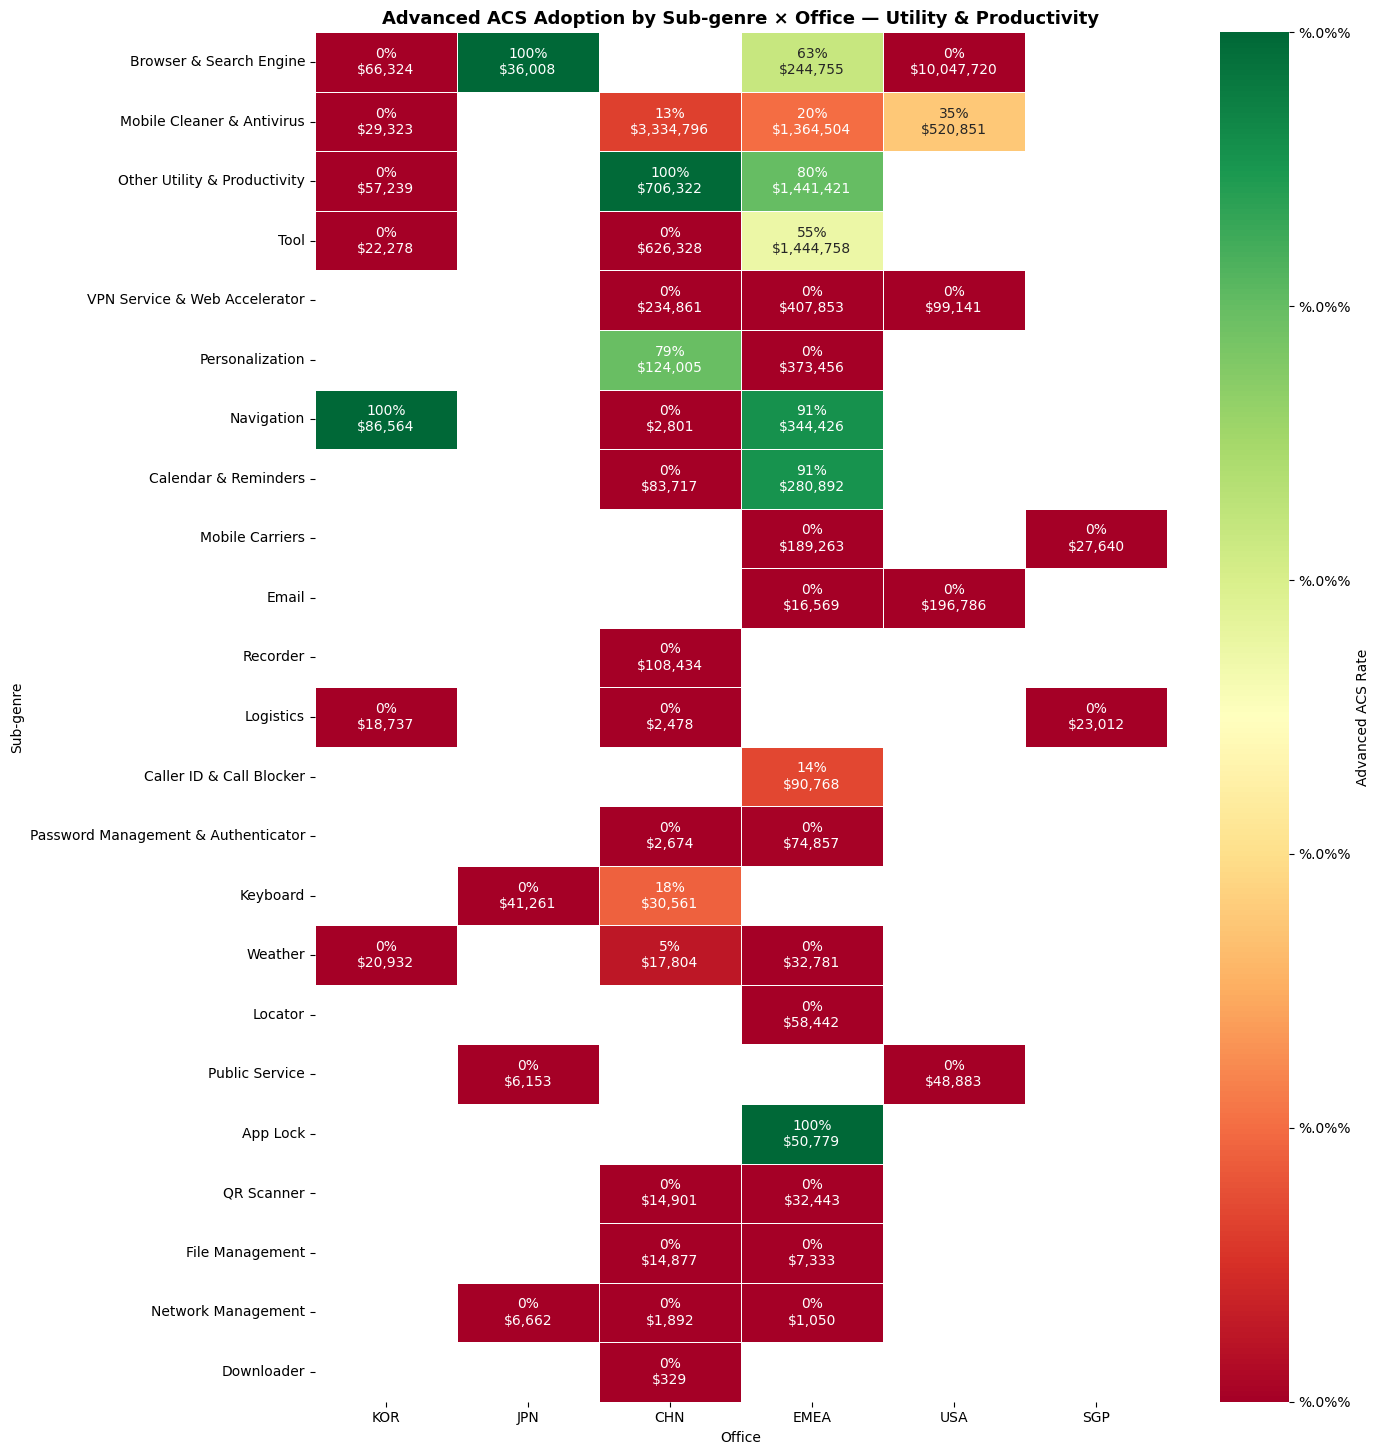

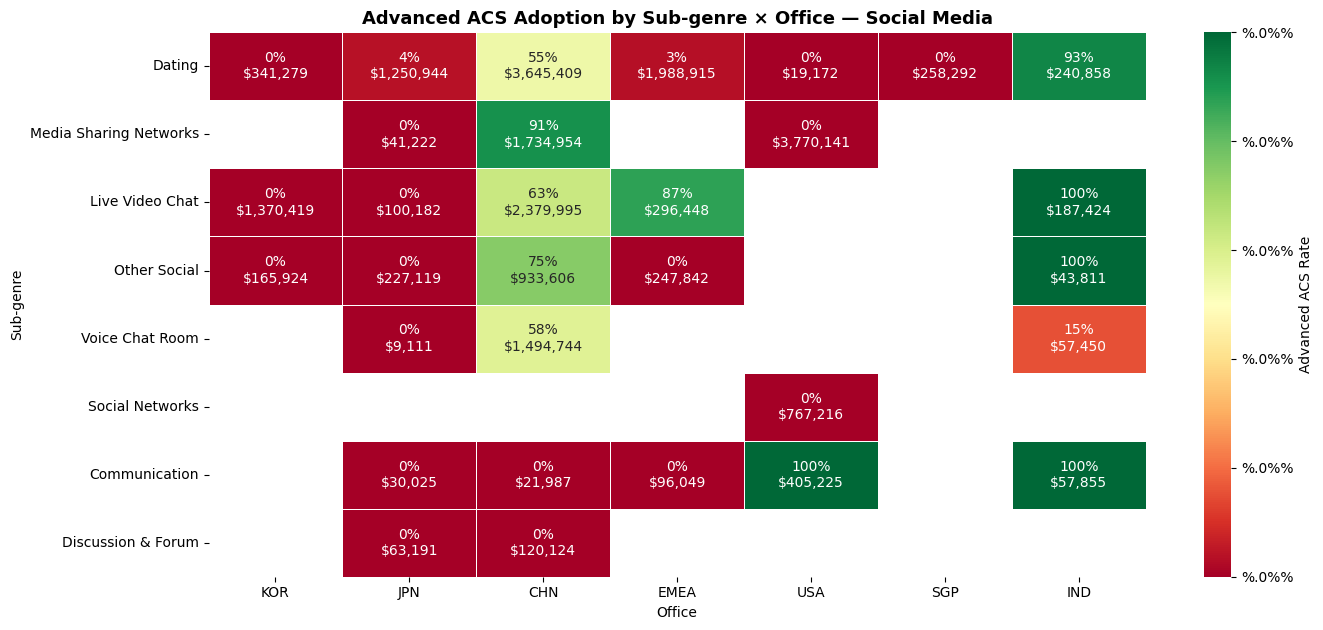

In [141]:
#@title 3-5. Heatmap per genre: Advanced ACS adoption by sub-genre × office

# Reuse office_order from cell 2-1 (sorted by Advanced spend share desc)
# office_order = ['IND', 'SGP', 'CHN', 'EMEA', 'UNKNOWN_OFFICE', 'USA', 'JPN', 'KOR']

# Build base data: Advanced adoption rate by office × genre × sub_genre
df_sg_total = (
    df.groupby(['office', 'genre', 'sub_genre'])
    .agg(total_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_sg_adv = (
    df[df['acs_mode'] == 'Advanced']
    .groupby(['office', 'genre', 'sub_genre'])
    .agg(adv_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_sg = df_sg_total.merge(df_sg_adv, on=['office', 'genre', 'sub_genre'], how='left')
df_sg['adv_spend'] = df_sg['adv_spend'].fillna(0)
df_sg['adv_rate'] = df_sg['adv_spend'] / df_sg['total_spend']

# Filter offices to those in office_order
valid_offices = [o for o in office_order if o in df_sg['office'].unique()]

# Get top genres by total spend
genres_ranked = (
    df_sg.groupby('genre')['total_spend'].sum()
    .sort_values(ascending=False)
    .head(12)
    .index.tolist()
)

for genre in genres_ranked:
    subset = df_sg[
        (df_sg['genre'] == genre) &
        (df_sg['office'].isin(valid_offices)) &
        (df_sg['total_spend'] >= MIN_SPEND_USD)
    ].copy()

    if subset.empty or subset['sub_genre'].nunique() < 2:
        continue

    # Pivot: sub_genre (rows) × office (cols) → adv_rate
    pivot = subset.pivot_table(
        index='sub_genre', columns='office', values='adv_rate', aggfunc='first'
    )

    # Reorder columns to match office_order
    cols_valid = [c for c in valid_offices if c in pivot.columns]
    cols_tmp = ['KOR','JPN','CHN','EMEA','USA','SGP','IND']
    cols = []
    for col in cols_tmp:
        if col in cols_valid:
            cols.append(col)
    pivot = pivot[cols]

    # Sort sub_genres by total spend descending
    sg_spend = (
        subset.groupby('sub_genre')['total_spend'].sum()
        .sort_values(ascending=False)
    )
    pivot = pivot.reindex(sg_spend.index).dropna(how='all')

    if pivot.empty or len(pivot) < 1:
        continue

    # Also build a spend matrix for annotation (show spend alongside rate)
    spend_pivot = subset.pivot_table(
        index='sub_genre', columns='office', values='total_spend', aggfunc='sum', fill_value=0
    ).reindex(index=pivot.index, columns=cols)

    # Create annotation: "rate\n$spend" or just rate
    annot = pivot.copy()
    for r in annot.index:
        for c in annot.columns:
            rate = pivot.loc[r, c]
            spend = spend_pivot.loc[r, c] if r in spend_pivot.index and c in spend_pivot.columns else 0
            if pd.isna(rate):
                annot.loc[r, c] = ''
            else:
                annot.loc[r, c] = f'{rate:.0%}\n${spend:,.0f}'

    fig_height = max(4, len(pivot) * 0.55 + 2)
    fig_sg, ax_sg = plt.subplots(figsize=(14, fig_height))
    sns.heatmap(
        pivot.astype(float),
        annot=annot.values,
        fmt='',
        cmap='RdYlGn',
        vmin=0, vmax=1,
        linewidths=0.5,
        ax=ax_sg,
        cbar_kws={'label': 'Advanced ACS Rate', 'format': '%.0%%'}
    )
    ax_sg.set_title(f'Advanced ACS Adoption by Sub-genre × Office — {genre}', fontsize=13, fontweight='bold')
    ax_sg.set_ylabel('Sub-genre')
    ax_sg.set_xlabel('Office')
    plt.tight_layout()
    plt.show()

---
## 4. Campaign Target Country Patterns by ACS Mode

Analyze how ACS mode varies by the campaign's target country. Focus on KOR/JPN-office advertisers and the countries they target.

In [142]:
#@title 4-1. ACS mode by campaign target country — KOR & JPN offices

df_country = (
    df_focus.groupby(['office', 'campaign_country', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_campaigns=('campaign_id', 'nunique')
    )
    .reset_index()
)
df_country['total_spend'] = (
    df_country.groupby(['office', 'campaign_country'])['spend'].transform('sum')
)
df_country['spend_share'] = df_country['spend'] / df_country['total_spend']

# Top target countries by spend for focus offices
top_countries = (
    df_country.groupby('campaign_country')['spend'].sum()
    .sort_values(ascending=False)
    .head(20)
    .index.tolist()
)

df_country_plot = df_country[
    df_country['campaign_country'].isin(top_countries)
].copy()
df_country_plot['acs_mode'] = pd.Categorical(
    df_country_plot['acs_mode'], categories=acs_order, ordered=True
)

for office in df_focus['office'].unique():
    subset = df_country_plot[df_country_plot['office'] == office]
    if subset.empty:
        continue
    # Sort countries by Advanced share
    country_order = (
        subset[subset['acs_mode'] == 'Advanced']
        .set_index('campaign_country')['spend_share']
        .reindex(top_countries, fill_value=0)
        .sort_values(ascending=False)
        .index.tolist()
    )

    fig_c = px.bar(
        subset,
        x='campaign_country',
        y='spend_share',
        color='acs_mode',
        category_orders={'campaign_country': country_order, 'acs_mode': acs_order},
        color_discrete_map={
            'Advanced': '#2563eb',
            'Recommended': '#60a5fa',
            'Conservative': '#fbbf24',
            'No ACS': '#d1d5db'
        },
        title=f'ACS Mode by Target Country — {office} Office (Spend Share)',
        labels={'spend_share': 'Spend Share', 'campaign_country': 'Target Country'},
        text_auto='.0%'
    )
    fig_c.update_layout(
        barmode='stack',
        yaxis_tickformat='.0%',
        height=500,
        xaxis_tickangle=-45
    )
    fig_c.show()

In [143]:
#@title 4-2. Compare: same target country, KOR/JPN vs global ACS adoption

# Global ACS adoption by target country
df_global_country = (
    df.groupby(['campaign_country', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_global_country['total_spend'] = (
    df_global_country.groupby('campaign_country')['spend'].transform('sum')
)
df_global_country['adv_share_global'] = (
    df_global_country.apply(
        lambda r: r['spend'] / r['total_spend'] if r['acs_mode'] == 'Advanced' else 0, axis=1
    )
)
global_adv = (
    df_global_country[df_global_country['acs_mode'] == 'Advanced']
    .set_index('campaign_country')['adv_share_global']
)

# Focus offices Advanced share by target country
for office in FOCUS_OFFICES:
    subset = df_country[df_country['office'] == office]
    focus_adv = (
        subset[subset['acs_mode'] == 'Advanced']
        .set_index('campaign_country')['spend_share']
    )

    comparison = pd.DataFrame({
        f'{office}_adv_share': focus_adv,
        'global_adv_share': global_adv
    }).dropna()
    comparison['gap'] = comparison[f'{office}_adv_share'] - comparison['global_adv_share']
    comparison = comparison.sort_values('gap')

    print(f"\n=== {office}: Advanced ACS Adoption Gap vs Global (by target country) ===")
    print(comparison.head(15).to_string(float_format='{:.1%}'.format))


=== KOR: Advanced ACS Adoption Gap vs Global (by target country) ===
                                      KOR_adv_share                global_adv_share                              gap
campaign_country                                                                                                    
GAB                 0.06927388076471360546768101212  0.9171038821012400775928862511  -0.8478300013365264721252052390
GIN                 0.01736691351618563646939315066  0.7932461569725930315251073546  -0.7758792434564073950557142039
BEN                 0.03361548467096461474424102105  0.7883580658696279365659248869  -0.7547425811986633218216838658
BOL                 0.03817236972862680531394364024  0.7683953685766464905006537865  -0.7302229988480196851867101463
ETH                 0.08801832998766211024888404616  0.7631572501429990845918794241  -0.6751389201553369743429953779
RUS                0.009278709796133112793652986994  0.6696276867704482892962392580  -0.66034897697431517650258

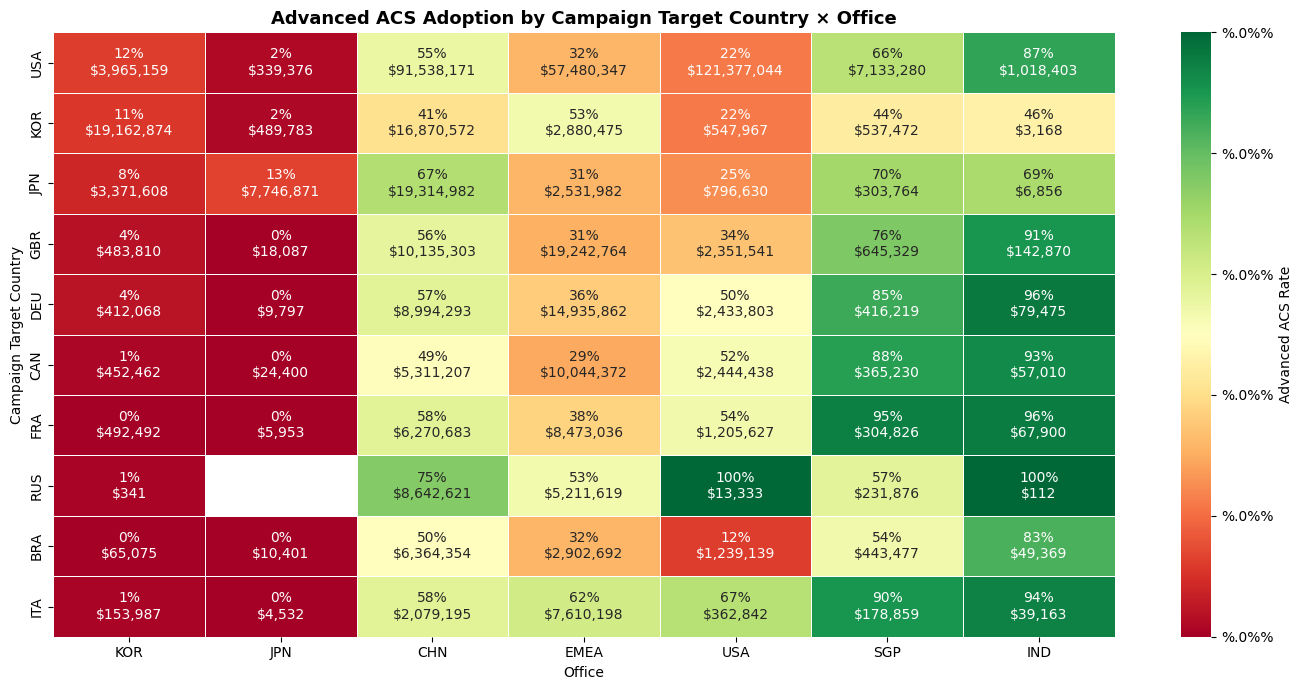

In [144]:
#@title 4-3. Heatmap: Advanced ACS adoption by campaign target country × office

TOP_COUNTRIES_NUM = 10

# Build base data: Advanced adoption rate by office × campaign_country
df_cc_total = (
    df.groupby(['office', 'campaign_country'])
    .agg(total_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_cc_adv = (
    df[df['acs_mode'] == 'Advanced']
    .groupby(['office', 'campaign_country'])
    .agg(adv_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_cc = df_cc_total.merge(df_cc_adv, on=['office', 'campaign_country'], how='left')
df_cc['adv_spend'] = df_cc['adv_spend'].fillna(0)
df_cc['adv_rate'] = df_cc['adv_spend'] / df_cc['total_spend']

# Filter offices
valid_offices = [o for o in office_order if o in df_cc['office'].unique()]

# Top campaign countries by total spend
top_countries = (
    df_cc.groupby('campaign_country')['total_spend'].sum()
    .sort_values(ascending=False)
    .head(TOP_COUNTRIES_NUM)
    .index.tolist()
)

subset = df_cc[
    (df_cc['office'].isin(valid_offices)) &
    (df_cc['campaign_country'].isin(top_countries)) &
    (df_cc['total_spend'] >= MIN_SPEND_USD)
].copy()

# Pivot: campaign_country (rows) × office (cols) → adv_rate
pivot = subset.pivot_table(
    index='campaign_country', columns='office', values='adv_rate', aggfunc='first'
)

# Match column order from section 3 heatmaps
cols_tmp = ['KOR','JPN','CHN','EMEA','USA','SGP','IND']
cols = [c for c in cols_tmp if c in pivot.columns]
pivot = pivot[cols]

# Sort countries by total spend descending
cc_spend = (
    subset.groupby('campaign_country')['total_spend'].sum()
    .sort_values(ascending=False)
)
pivot = pivot.reindex(cc_spend.index).dropna(how='all')

# Build spend matrix for annotation
spend_pivot = subset.pivot_table(
    index='campaign_country', columns='office', values='total_spend', aggfunc='sum', fill_value=0
).reindex(index=pivot.index, columns=cols)

# Create annotation: "rate\n$spend"
annot = pivot.copy()
for r in annot.index:
    for c in annot.columns:
        rate = pivot.loc[r, c]
        spend = spend_pivot.loc[r, c] if r in spend_pivot.index and c in spend_pivot.columns else 0
        if pd.isna(rate):
            annot.loc[r, c] = ''
        else:
            annot.loc[r, c] = f'{rate:.0%}\n${spend:,.0f}'

fig_height = max(6, len(pivot) * 0.5 + 2)
fig_cc, ax_cc = plt.subplots(figsize=(14, fig_height))
sns.heatmap(
    pivot.astype(float),
    annot=annot.values,
    fmt='',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    linewidths=0.5,
    ax=ax_cc,
    cbar_kws={'label': 'Advanced ACS Rate', 'format': '%.0%%'}
)
ax_cc.set_title('Advanced ACS Adoption by Campaign Target Country × Office', fontsize=13, fontweight='bold')
ax_cc.set_ylabel('Campaign Target Country')
ax_cc.set_xlabel('Office')
plt.tight_layout()
plt.show()

**Insight (4-3):**
The heatmap above shows the proportion of spend in each target market that comes from bundles using Advanced ACS mode, across offices.

If a market has a higher share of Advanced mode, we can infer that attribution competition is more intense in that market — advertisers in those markets are firing clicks more aggressively to compete for MMP attribution. For example, in **RUS** and **ITA**, all offices except KOR and JPN have more than 50% of their spend coming from Advanced mode, while KOR and JPN remain at ≤1%.

This pattern is consistent across most target countries: **KOR and JPN offices consistently show the lowest Advanced ACS adoption rates** regardless of the target market, reinforcing that the under-adoption is an office-level tendency rather than a market-specific one.

### 4-4. Lead List: Non-Advanced KOR/JPN Bundles with High Spend in Competitive Markets

Based on the heatmap above, target countries like **RUS, ITA, DEU, CAN, FRA** show strong Advanced ACS adoption globally — yet KOR/JPN offices lag behind. The table below surfaces specific bundles from KOR and JPN offices that are spending meaningfully in these competitive markets **without** Advanced ACS, representing activation opportunities.

In [145]:
#@title Lookup: app names from dim1_app

query_app_names = """
SELECT DISTINCT
  app_market_bundle,
  COALESCE(dataai.app_name, sensortower.app_name, matters42.app_name) AS app_name
FROM `moloco-ae-view.athena.dim1_app`
WHERE COALESCE(dataai.app_name, sensortower.app_name, matters42.app_name) IS NOT NULL
"""

df_app_names = process_query(query_app_names)
print(f"App name lookup: {len(df_app_names):,} bundles")
df_app_names.head()

App name lookup: 29,175,863 bundles


,app_market_bundle,app_name
0,6470715469,Take turns playing cards
1,1604181403,PokerOKK - Texas Hold'em Poker
2,653835024,The Ridge Preschool - Skoolbag
3,6553988219,Kool Beanz
4,6463043901,Hummus Bodega


In [146]:
#@title 4-4. Lead list: non-Advanced KOR/JPN bundles spending in competitive target countries

COMPETITIVE_COUNTRIES = ['RUS', 'ITA', 'DEU', 'CAN', 'FRA']

# Determine each bundle's ACS mode (product-level setting — use majority by spend)
bundle_acs_mode = (
    df_focus.groupby(['office', 'app_market_bundle', 'genre', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
    .sort_values('spend', ascending=False)
    .drop_duplicates(subset=['office', 'app_market_bundle'], keep='first')
    [['office', 'app_market_bundle', 'genre', 'acs_mode']]
    .rename(columns={'acs_mode': 'bundle_acs_mode'})
    .merge(df_app_names, on='app_market_bundle', how='left')
)

# Total spend per bundle across ALL target countries (denominator for share)
bundle_total_spend = (
    df_focus.groupby(['office', 'app_market_bundle'])
    .agg(bundle_total_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
bundle_total_spend['bundle_total_spend'] = bundle_total_spend['bundle_total_spend'].astype(float)

# Spend by bundle × target country in competitive markets
df_comp = (
    df_focus[df_focus['campaign_country'].isin(COMPETITIVE_COUNTRIES)]
    .groupby(['office', 'app_market_bundle', 'campaign_country'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_campaigns=('campaign_id', 'nunique'),
    )
    .reset_index()
)
df_comp['spend'] = df_comp['spend'].astype(float)

# Join bundle-level ACS mode and total spend, then filter to non-Advanced
df_lead_list = (
    df_comp
    .merge(bundle_acs_mode, on=['office', 'app_market_bundle'], how='left')
    .merge(bundle_total_spend, on=['office', 'app_market_bundle'], how='left')
)
df_non_adv = df_lead_list[df_lead_list['bundle_acs_mode'] != 'Advanced']

# Pivot: spend by target country, one row per bundle
df_lead_pivot = df_non_adv.pivot_table(
    index=['office', 'app_market_bundle', 'app_name', 'genre', 'bundle_acs_mode', 'bundle_total_spend'],
    columns='campaign_country',
    values='spend',
    aggfunc='sum',
    fill_value=0,
).reset_index()

country_cols = [c for c in COMPETITIVE_COUNTRIES if c in df_lead_pivot.columns]
df_lead_pivot['competitive_spend'] = df_lead_pivot[country_cols].sum(axis=1)
df_lead_pivot['competitive_share'] = df_lead_pivot['competitive_spend'] / df_lead_pivot['bundle_total_spend']
df_lead_pivot = df_lead_pivot.sort_values('competitive_spend', ascending=False)

print(f"Non-Advanced bundles spending in {', '.join(COMPETITIVE_COUNTRIES)}:")
print(f"  {df_lead_pivot['app_market_bundle'].nunique()} unique bundles")
print(f"  ${df_lead_pivot['competitive_spend'].sum():,.0f} spend in competitive markets")

display_cols = ['app_name', 'app_market_bundle', 'genre', 'bundle_acs_mode',
                'bundle_total_spend', 'competitive_spend', 'competitive_share'] + country_cols
fmt = {c: '${:,.0f}' for c in country_cols + ['bundle_total_spend', 'competitive_spend']}
fmt['competitive_share'] = '{:.1%}'

for office in FOCUS_OFFICES:
    subset = df_lead_pivot[df_lead_pivot['office'] == office][display_cols].head(20).reset_index(drop=True)
    if subset.empty:
        print(f"\n{office}: No leads found.")
        continue
    print(f"\n{'='*80}")
    print(f" {office} Office — Top Non-Advanced Bundles in Competitive Markets")
    print(f"{'='*80}")
    display(
        subset.style
        .format(fmt)
        .bar(subset=['competitive_spend'], color='#f4cccc')
        .background_gradient(subset=['competitive_share'], cmap='YlOrRd', vmin=0, vmax=1)
    )

Non-Advanced bundles spending in RUS, ITA, DEU, CAN, FRA:
  59 unique bundles
  $1,531,914 spend in competitive markets

 KOR Office — Top Non-Advanced Bundles in Competitive Markets


campaign_country,app_name,app_market_bundle,genre,bundle_acs_mode,bundle_total_spend,competitive_spend,competitive_share,RUS,ITA,DEU,CAN,FRA
0,"Azar: Video Chat, Meet Friends",972558973,Social Media,Recommended,"$1,039,429","$650,764",62.6%,$0,"$94,261","$229,467",$0,"$327,035"
1,MapleStory : Idle RPG,6739616715,RPG,Recommended,"$4,141,364","$194,001",4.7%,$0,$0,"$6,948","$185,273","$1,779"
2,MapleStory : Idle RPG,com.nexon.ma,RPG,Recommended,"$2,325,231","$152,391",6.6%,$0,$0,"$10,781","$140,849",$761
3,The Seven Deadly Sins,com.netmarble.nanagb,RPG,Recommended,"$276,389","$75,610",27.4%,$0,"$9,107","$20,118","$2,822","$43,564"
4,Solo Leveling:Arise,com.netmarble.sololv,RPG,Conservative,"$418,978","$74,114",17.7%,$0,$0,"$26,144","$6,443","$41,526"
5,Resident Evil Survival Unit,com.aniplex.resu,Strategy,Recommended,"$307,674","$60,731",19.7%,$0,"$2,718","$37,055",$0,"$20,959"
6,"Azar: Video Chat, Meet Friends",com.azarlive.android,Social Media,Recommended,"$76,063","$49,734",65.4%,$0,"$39,964","$4,255",$0,"$5,515"
7,GGVegas : Real Money Casino,6502815392,Games,Recommended,"$32,434","$32,434",100.0%,$0,$0,$0,"$32,434",$0
8,World War: Machines Conquest,com.bigbreakgames.wot,Strategy,Recommended,"$29,554","$27,127",91.8%,$0,$0,"$17,602",$0,"$9,525"
9,"WEBTOON: Manga, Comics, Manhwa",com.naver.linewebtoon,Books & Reference,Recommended,"$448,095","$25,841",5.8%,$0,$0,$0,"$25,841",$0



 JPN Office — Top Non-Advanced Bundles in Competitive Markets


campaign_country,app_name,app_market_bundle,genre,bundle_acs_mode,bundle_total_spend,competitive_spend,competitive_share,RUS,ITA,DEU,CAN,FRA
0,BAMEL – Random Video Chat,com.nadeshiko_android,Social Media,Recommended,"$82,258","$11,515",14.0%,$0,"$2,018","$5,799","$1,676","$2,023"
1,BAMEL ビデオ通話とスワイプでSNSを交換しよう。,6605938172,Social Media,Recommended,"$64,524","$6,756",10.5%,$0,"$1,856","$1,856","$1,848","$1,196"
2,The Battle Cats,850057092,Strategy,ACS_CUSTOM,"$82,783","$6,277",7.6%,$0,$21,$70,"$6,143",$43
3,Wizardry Variants Daphne,jp.co.drecom.wizardry.daphne,RPG,Recommended,"$153,844","$5,508",3.6%,$0,$0,$0,"$5,508",$0
4,Pew Pew Slime - Idle RPG,6739420338,RPG,Recommended,"$7,589","$3,428",45.2%,$0,$0,$513,"$1,586","$1,329"
5,BitcoinClub: Get Crypto Reward,bitcoinclub.app.android,Lifestyle,Recommended,"$37,869","$2,952",7.8%,$3,$40,$72,"$2,792",$45
6,Grand Summoners - Anime RPG,1329917539,RPG,Recommended,"$9,701","$2,093",21.6%,$0,$0,$0,"$2,093",$0
7,The Battle Cats,jp.co.ponos.battlecatsen,Strategy,ACS_CUSTOM,"$105,780","$1,922",1.8%,$0,$226,$326,"$1,172",$197
8,Pew Pew Slime - Idle RPG,com.xlegend.pewpewslime.global,RPG,Recommended,"$3,549","$1,400",39.4%,$0,$0,$422,$183,$796
9,FunnyTalk,1450366472,Education,Recommended,"$4,891",$984,20.1%,$0,$254,$465,$87,$179


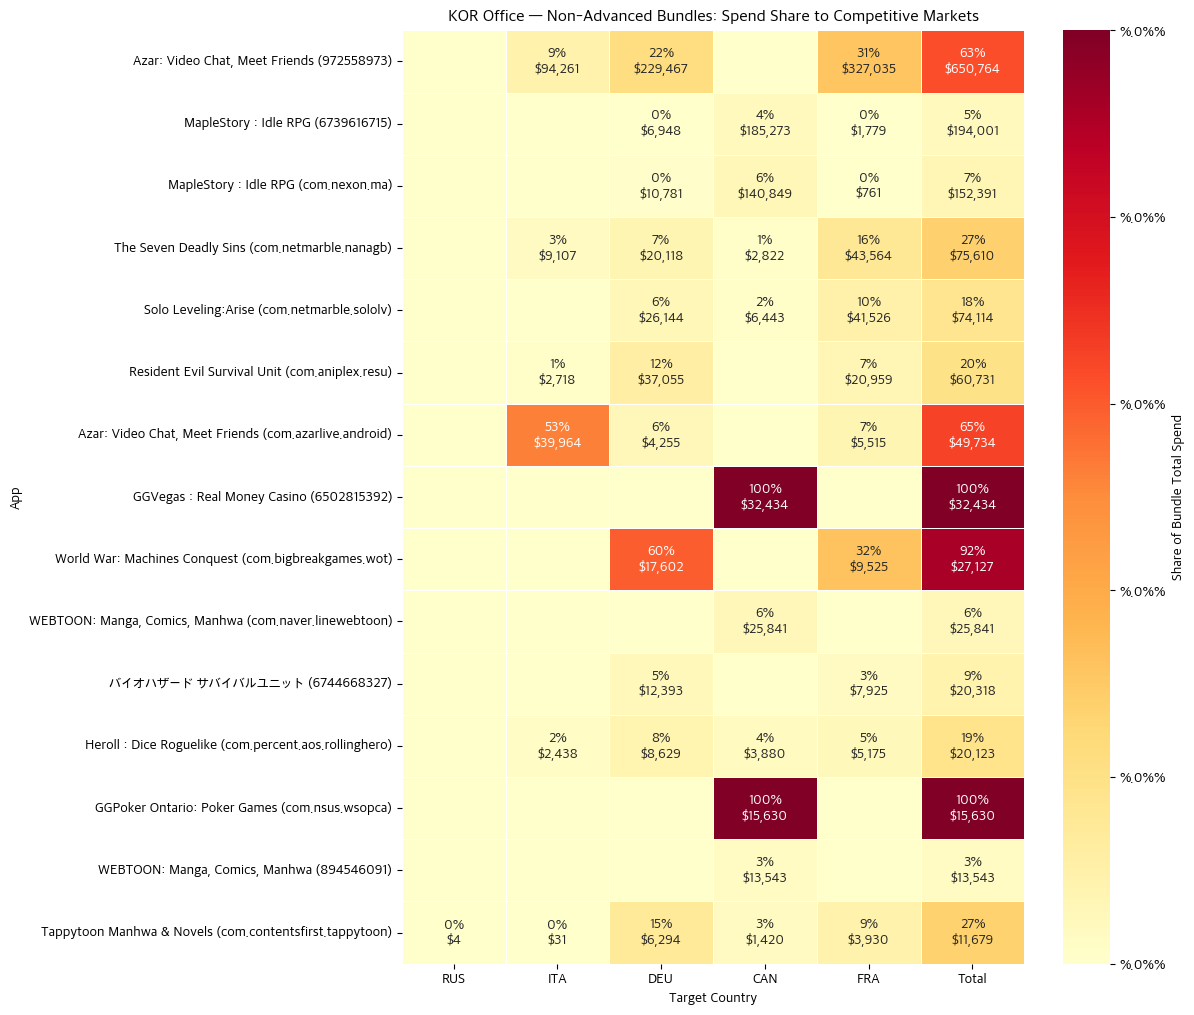

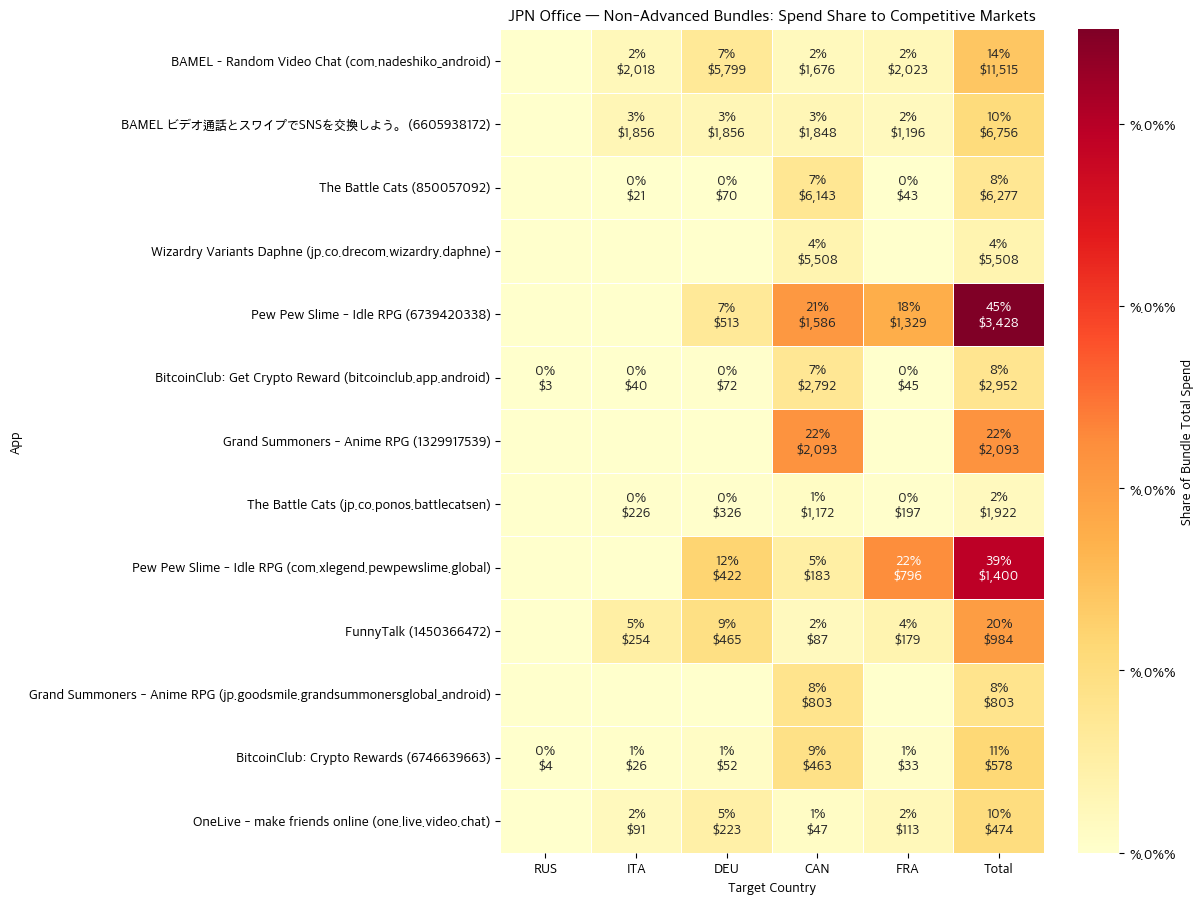

In [150]:
#@title 4-5. Heatmap: non-Advanced bundle spend share to competitive markets (KOR/JPN)

import matplotlib
matplotlib.rcParams['font.family'] = ['Apple SD Gothic Neo', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False

TOP_BUNDLES = 15

for office in FOCUS_OFFICES:
    subset = df_lead_pivot[df_lead_pivot['office'] == office].head(TOP_BUNDLES).copy()
    if subset.empty:
        print(f"{office}: No non-Advanced bundles in competitive markets.")
        continue

    country_cols = [c for c in COMPETITIVE_COUNTRIES if c in subset.columns]
    # Display as "App Name (bundle_id)"; fall back to bundle ID if no name
    subset['display_name'] = np.where(
        subset['app_name'].notna(),
        subset['app_name'] + ' (' + subset['app_market_bundle'] + ')',
        subset['app_market_bundle'],
    )
    pivot_spend = subset.set_index('display_name')[country_cols].astype(float)
    totals = subset.set_index('display_name')['bundle_total_spend'].astype(float)

    # Add a "Total" column: total competitive spend and its share
    pivot_spend['Total'] = pivot_spend[country_cols].sum(axis=1)
    all_cols = country_cols + ['Total']

    # Compute share: country spend / bundle total spend
    pivot_share = pivot_spend.div(totals, axis=0)

    # Annotation: share % + dollar amount
    annot = pivot_share.copy()
    for r in annot.index:
        for c in all_cols:
            spend = pivot_spend.loc[r, c]
            share = pivot_share.loc[r, c]
            if spend > 0:
                annot.loc[r, c] = f'{share:.0%}\n${spend:,.0f}'
            else:
                annot.loc[r, c] = ''

    fig, ax = plt.subplots(figsize=(12, max(4, len(pivot_share) * 0.55 + 2)))
    sns.heatmap(
        pivot_share[all_cols],
        annot=annot[all_cols].values,
        fmt='',
        cmap='YlOrRd',
        vmin=0,
        linewidths=0.5,
        ax=ax,
        cbar_kws={'label': 'Share of Bundle Total Spend', 'format': '%.0%%'}
    )
    ax.set_title(
        f'{office} Office — Non-Advanced Bundles: Spend Share to Competitive Markets',
        fontsize=12, fontweight='bold'
    )
    ax.set_ylabel('App')
    ax.set_xlabel('Target Country')
    plt.tight_layout()
    plt.show()

---
## 5. Combined View: Genre × Target Country × ACS Mode (KOR & JPN)

Cross-tabulate genre and target country to find specific segments where ACS Advanced is under-adopted in KOR/JPN.

In [ ]:
#@title 5-1. Non-Advanced bundles in KOR & JPN with significant spend

# Products actively spending but NOT on Advanced ACS in KOR/JPN
df_non_adv = (
    df_focus[df_focus['acs_mode'] != 'Advanced']
    .groupby(['office', 'product_id', 'app_market_bundle', 'genre', 'sub_genre', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_campaigns=('campaign_id', 'nunique'),
        countries=('campaign_country', lambda x: ', '.join(sorted(x.unique())))
    )
    .reset_index()
    .sort_values('spend', ascending=False)
)

print(f"Total non-Advanced products in KOR/JPN: {df_non_adv['product_id'].nunique()}")
print(f"Total spend on non-Advanced: ${df_non_adv['spend'].sum():,.0f}")
print()
print("Top 30 non-Advanced products by spend:")
df_non_adv.head(30)

Total non-Advanced products in KOR/JPN: 710
Total spend on non-Advanced: $35,218,661

Top 30 non-Advanced products by spend:


,office,product_id,app_market_bundle,genre,sub_genre,acs_mode,spend,n_campaigns,countries
586,KOR,k8vOAXuuyirA2X83,6739616715,RPG,Idle RPG,Recommended,2471431.666695044,32,"ARE, AUS, BRA, CAN, DEU, ESP, FRA, GBR, HKG, M..."
420,KOR,NwnCn0wf9qYwKE1r,6739616715,RPG,Idle RPG,Recommended,1669932.346024585,1,KOR
443,KOR,RmvGyyl3IzIpyQ6r,com.coupang.mobile,Shopping,E-Commerce,ACS_CUSTOM,1596773.310267023,7,KOR
438,KOR,RHM0iFphg6QNmrej,6739188587,Food & Drink,Food Delivery & Carryout,Recommended,1537185.219952654,16,JPN
440,KOR,RQeyz3Fz10woNsgj,com.nexon.ma,RPG,Idle RPG,Recommended,1287957.346056398,4,KOR
570,KOR,hnCilLqDRdOdB8ck,com.nexon.ma,RPG,Idle RPG,Recommended,1037274.141744284,34,"ARE, AUS, BRA, CAN, DEU, ESP, FRA, GBR, HKG, I..."
197,JPN,g3gkn811486wje2hlyyx,299147843,News & Magazines,News,ACS_CUSTOM,923431.571341476,3,JPN
546,KOR,fFuMx1cIa5ACsThy,com.towneers.www,Lifestyle,Local Service,Recommended,870613.775474644,11,KOR
679,KOR,vVkgHc3l6dkOM1rr,com.netmarble.tskgb,RPG,Team Battle,ACS_CUSTOM,810671.464809625,12,"ABW, AGO, AIA, ALA, ALB, AND, ARE, ARG, ARM, A..."
654,KOR,tBaQm6EdZSDMsOzF,6482291732,Strategy,Tower Defense Strategy,Recommended,748499.391539631,18,"ABW, AFG, AGO, AIA, ALA, ALB, AND, ARE, ARG, A..."


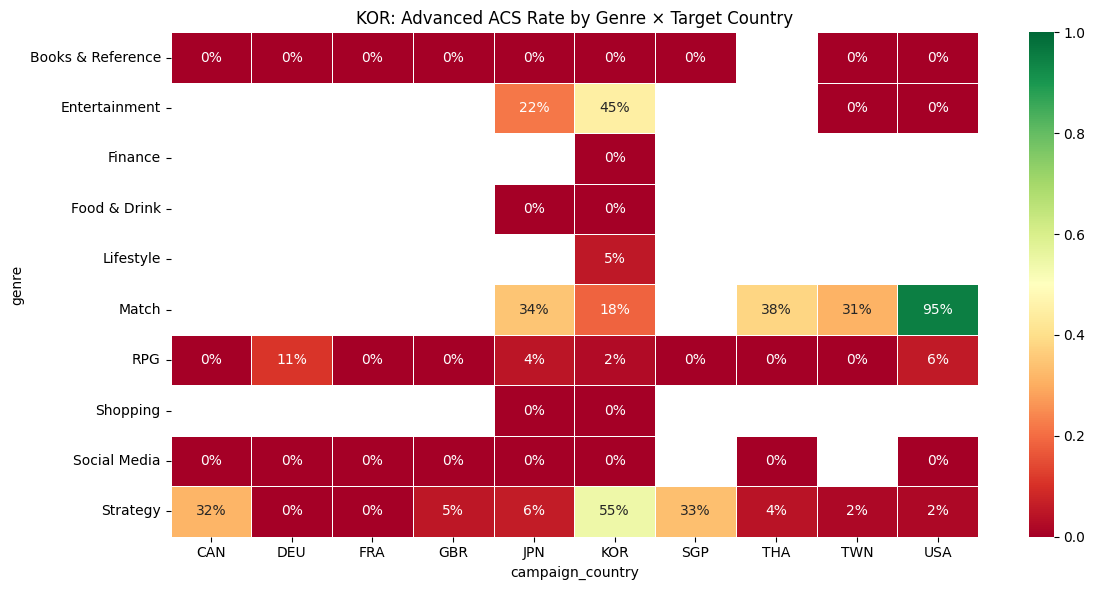

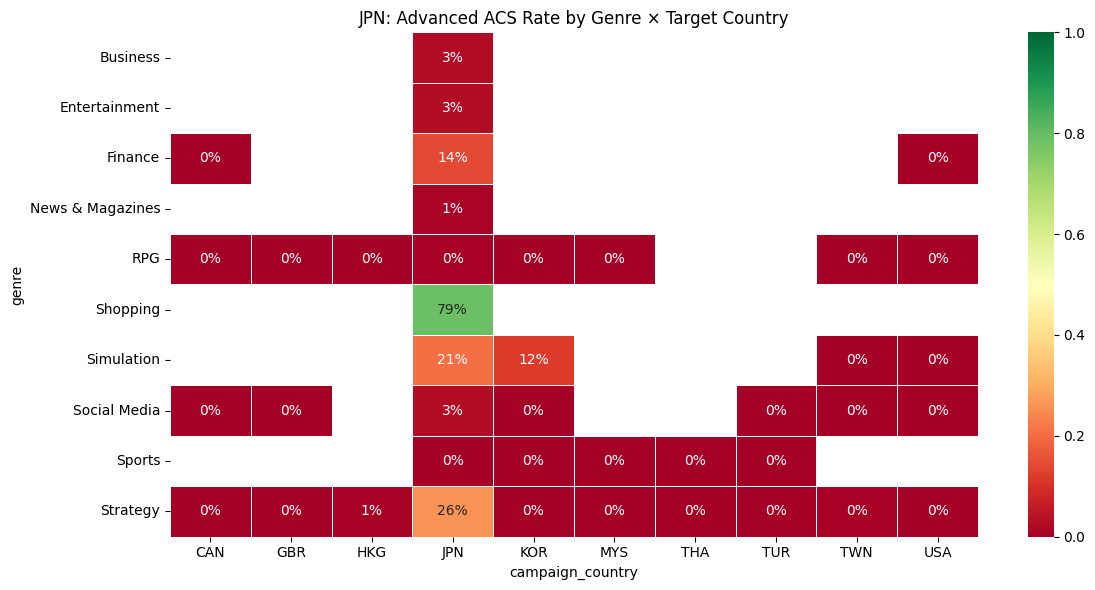

In [ ]:
#@title 5-2. Genre × ACS mode summary for KOR/JPN

df_genre_country_acs = (
    df_focus.groupby(['office', 'genre', 'campaign_country', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_products=('product_id', 'nunique')
    )
    .reset_index()
)

# Show Advanced adoption rate by genre × campaign_country for each focus office
for office in FOCUS_OFFICES:
    subset = df_genre_country_acs[df_genre_country_acs['office'] == office]
    total = subset.groupby(['genre', 'campaign_country'])['spend'].sum().reset_index(name='total_spend')
    adv = (
        subset[subset['acs_mode'] == 'Advanced']
        .groupby(['genre', 'campaign_country'])['spend'].sum()
        .reset_index(name='adv_spend')
    )
    merged = total.merge(adv, on=['genre', 'campaign_country'], how='left')
    merged['adv_spend'] = merged['adv_spend'].fillna(0)
    merged['adv_rate'] = merged['adv_spend'] / merged['total_spend']

    # Pivot: genre × country → adv_rate
    pivot = merged.pivot_table(
        index='genre', columns='campaign_country', values='adv_rate', fill_value=np.nan
    )
    # Only show countries with meaningful spend
    spend_pivot = merged.pivot_table(
        index='genre', columns='campaign_country', values='total_spend', fill_value=0
    )
    # Mask cells with < MIN_SPEND_USD
    pivot = pivot.where(spend_pivot >= MIN_SPEND_USD)
    # Keep top countries and genres
    top_cols = spend_pivot.sum().sort_values(ascending=False).head(10).index.tolist()
    top_rows = spend_pivot.sum(axis=1).sort_values(ascending=False).head(10).index.tolist()
    pivot = pivot.loc[
        pivot.index.isin(top_rows),
        pivot.columns.isin(top_cols)
    ]

    fig_hm, ax_hm = plt.subplots(figsize=(12, 6))
    sns.heatmap(
        pivot,
        annot=True, fmt='.0%',
        cmap='RdYlGn',
        vmin=0, vmax=1,
        linewidths=0.5,
        ax=ax_hm
    )
    ax_hm.set_title(f'{office}: Advanced ACS Rate by Genre × Target Country')
    plt.tight_layout()
    plt.show()

---
## 6. ACS Mode Trend Over Time

Track how ACS mode distribution has changed over the analysis period, focusing on KOR/JPN.

In [ ]:
#@title 6-1. Weekly ACS mode trend — KOR & JPN

df_focus['week'] = pd.to_datetime(df_focus['date_utc']).dt.to_period('W').apply(lambda r: r.start_time)

df_trend = (
    df_focus.groupby(['office', 'week', 'acs_mode'])
    .agg(spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_trend['total_spend'] = df_trend.groupby(['office', 'week'])['spend'].transform('sum')
df_trend['spend_share'] = df_trend['spend'] / df_trend['total_spend']

for office in FOCUS_OFFICES:
    subset = df_trend[df_trend['office'] == office].copy()
    subset['acs_mode'] = pd.Categorical(subset['acs_mode'], categories=acs_order, ordered=True)

    fig_t = px.area(
        subset,
        x='week',
        y='spend_share',
        color='acs_mode',
        category_orders={'acs_mode': acs_order},
        color_discrete_map={
            'Advanced': '#2563eb',
            'Recommended': '#60a5fa',
            'Conservative': '#fbbf24',
            'No ACS': '#d1d5db'
        },
        title=f'{office}: ACS Mode Trend (Weekly Spend Share)',
        labels={'spend_share': 'Spend Share', 'week': 'Week'},
    )
    fig_t.update_layout(
        yaxis_tickformat='.0%',
        height=400
    )
    fig_t.show()

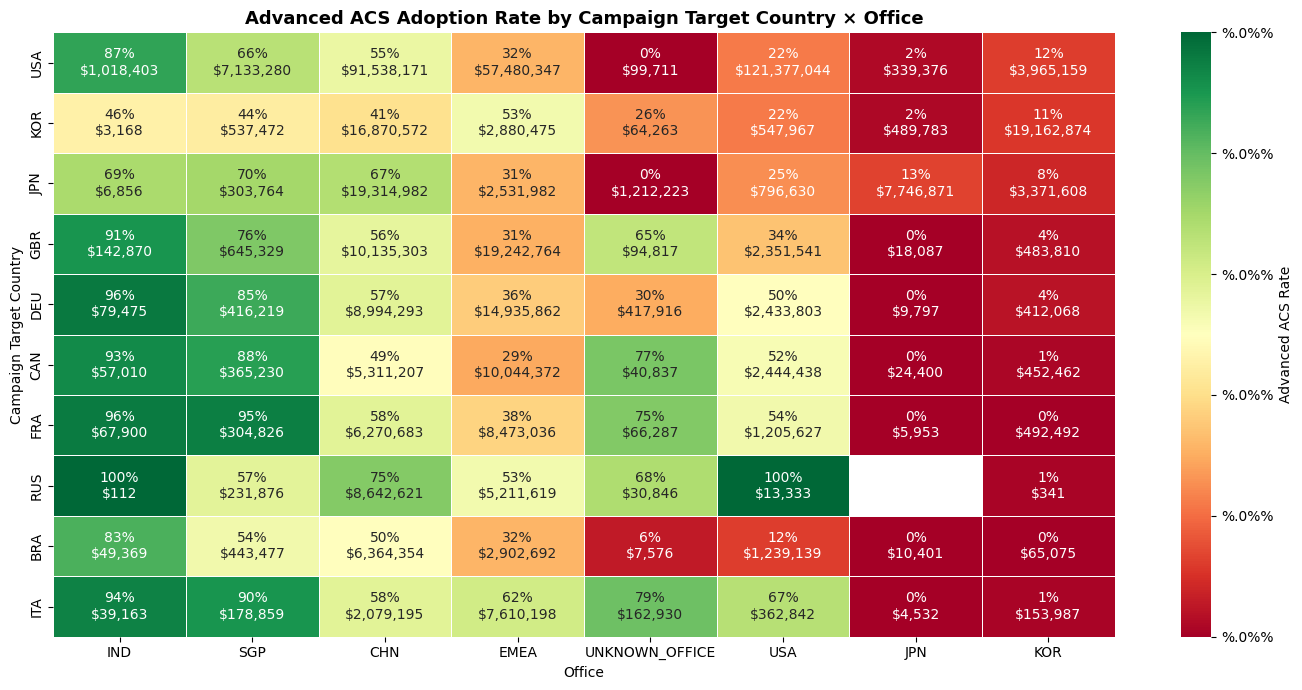

In [ ]:
#@title 6-2. Heatmap: Advanced ACS adoption by campaign_country × office

TOP_COUNTRIES_NUM = 10

# Build base data: Advanced adoption rate by office × campaign_country
df_cc_total = (
    df.groupby(['office', 'campaign_country'])
    .agg(total_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_cc_adv = (
    df[df['acs_mode'] == 'Advanced']
    .groupby(['office', 'campaign_country'])
    .agg(adv_spend=('gross_spend_usd', 'sum'))
    .reset_index()
)
df_cc = df_cc_total.merge(df_cc_adv, on=['office', 'campaign_country'], how='left')
df_cc['adv_spend'] = df_cc['adv_spend'].fillna(0)
df_cc['adv_rate'] = df_cc['adv_spend'] / df_cc['total_spend']

# Filter offices to those in office_order
valid_offices = [o for o in office_order if o in df_cc['office'].unique()]

# Top campaign countries by total spend
top_countries = (
    df_cc.groupby('campaign_country')['total_spend'].sum()
    .sort_values(ascending=False)
    .head(TOP_COUNTRIES_NUM)
    .index.tolist()
)

subset = df_cc[
    (df_cc['office'].isin(valid_offices)) &
    (df_cc['campaign_country'].isin(top_countries)) &
    (df_cc['total_spend'] >= MIN_SPEND_USD)
].copy()

# Pivot: campaign_country (rows) × office (cols) → adv_rate
pivot = subset.pivot_table(
    index='campaign_country', columns='office', values='adv_rate', aggfunc='first'
)
cols = [c for c in valid_offices if c in pivot.columns]
pivot = pivot[cols]

# Sort countries by total spend descending
cc_spend = (
    subset.groupby('campaign_country')['total_spend'].sum()
    .sort_values(ascending=False)
)
pivot = pivot.reindex(cc_spend.index).dropna(how='all')

# Build spend matrix for annotation
spend_pivot = subset.pivot_table(
    index='campaign_country', columns='office', values='total_spend', aggfunc='sum', fill_value=0
).reindex(index=pivot.index, columns=cols)

# Create annotation: "rate\n$spend"
annot = pivot.copy()
for r in annot.index:
    for c in annot.columns:
        rate = pivot.loc[r, c]
        spend = spend_pivot.loc[r, c] if r in spend_pivot.index and c in spend_pivot.columns else 0
        if pd.isna(rate):
            annot.loc[r, c] = ''
        else:
            annot.loc[r, c] = f'{rate:.0%}\n${spend:,.0f}'

fig_height = max(6, len(pivot) * 0.5 + 2)
fig_cc, ax_cc = plt.subplots(figsize=(14, fig_height))
sns.heatmap(
    pivot.astype(float),
    annot=annot.values,
    fmt='',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    linewidths=0.5,
    ax=ax_cc,
    cbar_kws={'label': 'Advanced ACS Rate', 'format': '%.0%%'}
)
ax_cc.set_title('Advanced ACS Adoption Rate by Campaign Target Country × Office', fontsize=13, fontweight='bold')
ax_cc.set_ylabel('Campaign Target Country')
ax_cc.set_xlabel('Office')
plt.tight_layout()
plt.show()

---
## 7. Opportunity Sizing

Estimate the spend currently running on non-Advanced ACS modes in KOR/JPN, segmented by genre/sub-genre and campaign country, to size the upgrade opportunity.

In [ ]:
#@title 7-1. Opportunity sizing: spend on non-Advanced in KOR/JPN

df_opp = (
    df_focus.groupby(['office', 'genre', 'acs_mode'])
    .agg(
        spend=('gross_spend_usd', 'sum'),
        n_products=('product_id', 'nunique'),
        n_campaigns=('campaign_id', 'nunique')
    )
    .reset_index()
)

# Non-advanced spend
df_non_adv_summary = df_opp[df_opp['acs_mode'] != 'Advanced'].copy()
df_non_adv_summary = df_non_adv_summary.sort_values(['office', 'spend'], ascending=[True, False])

print("=== Non-Advanced ACS Spend in KOR/JPN by Genre ===")
for office in FOCUS_OFFICES:
    sub = df_non_adv_summary[df_non_adv_summary['office'] == office]
    total_non_adv = sub['spend'].sum()
    total_all = df_opp[df_opp['office'] == office]['spend'].sum()
    print(f"\n--- {office} ---")
    print(f"Non-Advanced spend: ${total_non_adv:,.0f} ({total_non_adv/total_all:.1%} of total)")
    print(sub.groupby('genre')['spend'].sum().sort_values(ascending=False).head(10).to_string())

=== Non-Advanced ACS Spend in KOR/JPN by Genre ===

--- KOR ---
Non-Advanced spend: $27,256,396 (89.7% of total)
genre
RPG                  10558462.013537540
Shopping              3222185.632099276
Food & Drink          2312443.657216053
Strategy              2083647.719769450
Social Media          1877622.678118140
Books & Reference     1144232.607940833
Lifestyle             1076369.652384681
Finance                997845.403152678
Entertainment          657847.181550893
Match                  509627.284507173

--- JPN ---
Non-Advanced spend: $8,132,785 (88.7% of total)
genre
Social Media        1676742.278228792
Business            1301512.711923156
News & Magazines     938456.470879171
Strategy             929447.002045682
Simulation           806619.199960464
RPG                  672969.509292392
Finance              386046.245861961
Entertainment        269105.453935100
Sports               262627.484453416
Shopping             143186.634596197


---
## 8. ACS Advanced Adoption by Bundle Creative Format Mix

For each bundle, compute the **creative format composition** (share of engaged format - VI / NV / RI, and Banner spend) and analyze how it relates to ACS Advanced adoption — broken out across offices.

Key questions:
- Do Advanced bundles skew toward certain formats (e.g., more engaged formats) relative to non-Advanced bundles?
- For each creative format (or creative format category), which offices show low Advanced adoption?
- Do KOR/JPN offices differ from others in how format mix and Advanced adoption correlate?

In [ ]:
#@title 8-0. Sample: check unique cr_format values in fact_dsp_creative

query_fmt_sample = """
SELECT
  creative.format AS cr_format,
  COUNT(*)                                  AS n_rows,
  ROUND(SUM(gross_spend_usd) / 1e6, 2)     AS spend_usd_m
FROM `moloco-ae-view.athena.fact_dsp_creative`
WHERE date_utc BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
                   AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
  AND gross_spend_usd > 0
GROUP BY 1
ORDER BY 3 DESC
LIMIT 30
"""

df_fmt_sample = process_query(query_fmt_sample)
print(df_fmt_sample.to_string(index=False))

cr_format   n_rows  spend_usd_m
       vi 64244965 31.610000000
       ri 14879499 13.990000000
       ib 71330531  5.290000000
       ni 24651087  1.760000000
       nv 14868311  1.730000000
       ii  5210543  1.340000000
       vb  7163946  1.280000000
       nl 11997633  0.830000000
       db   279999  0.140000000
       di   103954  0.040000000


In [152]:
#@title 8. Query: spend by bundle × cr_format × ACS mode (fact_dsp_creative)

query_format_mix = f"""
WITH acs_product AS (
  SELECT
    JSON_VALUE(digest_json, '$.id') AS product_id,
    `date` AS date_utc,
    COALESCE(
      JSON_VALUE(original_json, '$.inventory_feature.acs_type'),
      'NO_ACS'
    ) AS acs_type
  FROM `ads-bpd-guard-china.standard_digest.history_digest`
  WHERE type = 'PRODUCT'
    AND `date` BETWEEN '{START_DATE}' AND '{END_DATE}'
    AND platform != 'MOLOCO'
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY JSON_VALUE(digest_json, '$.id'), `date`
    ORDER BY `date` DESC
  ) = 1
)
SELECT
  advertiser.office                   AS office,
  f.product_id,
  product.app_market_bundle           AS app_market_bundle,
  creative.format                     AS cr_format,
  COALESCE(a.acs_type, 'NO_ACS')      AS acs_mode,
  SUM(f.gross_spend_usd)              AS gross_spend_usd
FROM `moloco-ae-view.athena.fact_dsp_creative` f
LEFT JOIN acs_product a
  ON f.product_id = a.product_id
 AND f.date_utc   = a.date_utc
WHERE f.date_utc BETWEEN '{START_DATE}' AND '{END_DATE}'
  AND f.gross_spend_usd > 0
GROUP BY ALL
ORDER BY office, app_market_bundle, cr_format
"""

df_fmt = process_query(query_format_mix)
print(f"Rows: {len(df_fmt):,}")
print(f"\nACS mode distribution:")
print(df_fmt.groupby('acs_mode')['gross_spend_usd'].sum().astype(float).sort_values(ascending=False).apply(lambda x: f"${x/1e6:.1f}M"))

Rows: 74,118

ACS mode distribution:
acs_mode
ACS_STANDARD_RECOMMENDED     $289.3M
ACS_STANDARD_ADVANCED        $266.0M
ACS_CUSTOM                    $47.1M
ACS_STANDARD_CONSERVATIVE     $44.3M
NO_ACS                         $8.9M
ACS_UNKNOWN                    $0.6M
Name: gross_spend_usd, dtype: object


In [155]:
#@title Format categorization + bundle-level profile
# ⚠️ Run 8-0 first to see actual cr_format values, then adjust the mapping below if needed.

FORMAT_MAP = {
    # Add/adjust based on actual values seen in 8-0
    # e.g. 'VIDEO_INTERSTITIAL': 'VI', 'NATIVE': 'NV', ...
}

def categorize_format(fmt):
    if fmt is None or (isinstance(fmt, float) and pd.isna(fmt)):
        return 'Other'
    s = str(fmt).upper()
    # Direct map first
    if s in FORMAT_MAP:
        return FORMAT_MAP[s]
    # Pattern fallback
    if 'VIDEO_INTERSTITIAL' in s or s == 'VI':
        return 'VI'
    if 'NATIVE' in s or s == 'NV':
        return 'NV'
    if 'RICH_INTERSTITIAL' in s or 'REWARDED_INTERSTITIAL' in s or s == 'RI':
        return 'RI'
    if 'BANNER' in s:
        return 'Banner'
    return 'Other'

df_fmt['format_cat'] = df_fmt['cr_format'].apply(categorize_format)

print("format_cat distribution (after mapping):")
print(
    df_fmt.groupby('format_cat')['gross_spend_usd'].sum().astype(float)
    .sort_values(ascending=False)
    .apply(lambda x: f"${x/1e6:.1f}M")
)

# --- Bundle-level: dominant ACS mode (by spend) ---
bundle_total = (
    df_fmt.groupby(['office', 'product_id', 'app_market_bundle'])['gross_spend_usd']
    .sum().reset_index(name='bundle_total_spend')
)
bundle_acs = (
    df_fmt.groupby(['office', 'product_id', 'app_market_bundle', 'acs_mode'])['gross_spend_usd']
    .sum().reset_index()
)
bundle_dom_acs = bundle_acs.loc[
    bundle_acs.groupby(['office', 'product_id', 'app_market_bundle'])['gross_spend_usd'].idxmax(),
    ['office', 'product_id', 'app_market_bundle', 'acs_mode']
]

# --- Bundle-level format mix (spend share per format_cat) ---
bundle_fmt = (
    df_fmt.groupby(['office', 'product_id', 'app_market_bundle', 'format_cat'])['gross_spend_usd']
    .sum().reset_index()
)
bundle_fmt = bundle_fmt.merge(bundle_total, on=['office', 'product_id', 'app_market_bundle'])
bundle_fmt['fmt_share'] = bundle_fmt['gross_spend_usd'] / bundle_fmt['bundle_total_spend']

# One row per bundle: format shares as columns + dominant ACS mode
bundle_profile = bundle_fmt.pivot_table(
    index=['office', 'product_id', 'app_market_bundle', 'bundle_total_spend'],
    columns='format_cat', values='fmt_share', fill_value=0
).reset_index()
bundle_profile.columns.name = None
bundle_profile = bundle_profile.merge(bundle_dom_acs, on=['office', 'product_id', 'app_market_bundle'])
bundle_profile['is_advanced'] = (bundle_profile['acs_mode'] == 'ACS_STANDARD_ADVANCED')

print(f"\nBundle profiles: {len(bundle_profile):,}")
print(bundle_profile.groupby('is_advanced')['bundle_total_spend'].sum().astype(float).apply(lambda x: f"${x/1e6:.1f}M"))

format_cat distribution (after mapping):
format_cat
VI       $380.0M
Other    $129.5M
RI       $126.0M
NV        $20.8M
Name: gross_spend_usd, dtype: object

Bundle profiles: 19,957
is_advanced
False    $379.9M
True     $266.9M
Name: bundle_total_spend, dtype: object


In [156]:
#@title 8-2. Heatmap: ACS Advanced adoption rate by creative format × office

# For each office × format_cat: what % of spend on that format is on Advanced?
hm_total = (
    df_fmt.groupby(['office', 'format_cat'])['gross_spend_usd']
    .sum().reset_index(name='total_spend')
)
hm_adv = (
    df_fmt[df_fmt['acs_mode'] == 'ACS_STANDARD_ADVANCED']
    .groupby(['office', 'format_cat'])['gross_spend_usd']
    .sum().reset_index(name='adv_spend')
)
hm = hm_total.merge(hm_adv, on=['office', 'format_cat'], how='left').fillna({'adv_spend': 0})
hm['adv_rate'] = hm['adv_spend'] / hm['total_spend']

# Filter: offices with ≥$10K spend on that format, top 15 offices overall
min_fmt_spend = 10_000
top_offices_hm = (
    df_fmt.groupby('office')['gross_spend_usd'].sum()
    .nlargest(15).index.tolist()
)
hm_top = hm[(hm['office'].isin(top_offices_hm)) & (hm['total_spend'] >= min_fmt_spend)]

# Pivot
pivot_fmt = hm_top.pivot_table(index='format_cat', columns='office', values='adv_rate')

# Sort offices by overall Advanced adoption (high → low, same order as chart 8-1)
office_col_order = [o for o in adv_share_order if o in pivot_fmt.columns]
pivot_fmt = pivot_fmt[office_col_order]

# Sort rows by canonical format order
fmt_row_order = [f for f in format_order if f in pivot_fmt.index]
pivot_fmt = pivot_fmt.loc[fmt_row_order]

fig, ax = plt.subplots(figsize=(max(10, len(office_col_order) * 0.85), 4))
sns.heatmap(
    pivot_fmt,
    annot=True, fmt='.0%',
    cmap='RdYlGn', vmin=0, vmax=1,
    linewidths=0.5, linecolor='white',
    ax=ax,
    cbar_kws={'label': 'Advanced Adoption Rate'},
)
ax.set_title(
    '8-2. ACS Advanced Adoption Rate by Creative Format × Office\n'
    '(offices sorted high→low by overall Advanced adoption; blanks = <$10K spend)',
    fontsize=12,
)
ax.set_xlabel('')
ax.set_ylabel('Creative Format')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

TypeError: Cannot use method 'nlargest' with dtype object